### Problem: Multiclass Classification

### Introduction

Inputs:

Ia: Current in line A

Ib: Current in line B

Ic: Current in line C

Va: Voltage in line A

Vb: Voltage in line B

Vc: Voltage in line C

Outputs:

[G C B A]

Examples:

[0 0 0 0] - No Fault

[1 0 0 1] - LG fault (Between Phase A and Ground)

[0 1 1 0] - LL fault (Between Phase B and Phase C)

[1 0 1 1] - LLG Fault (Between Phases A, B and Ground)

[0 1 1 1] - LLL Fault (Between all three phases)

[1 1 1 1] - LLLG fault (Three phase symmetrical fault)

In [6]:
#Installing the relevant libraries
!pip install mlxtend
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/bc/43/242432efc3f60052a4a534dc4926b21e236ab4ec8d4920c593da3f65c65d/xgboost-2.0.2-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 326.8 kB/s eta 0:05:06
   ---------------------------------------- 0.1/99.8 MB 409.6 kB/s eta 0:04:04
   ---------------------------------------- 0.1/99.8 MB 502.0 kB/s eta 0:03:19
   ---------------------------------------- 0.1/99.8 MB 552.2 kB/s eta 0:03:01
   ---------------------------------------- 0.2/99.8 MB 692.9 kB/s eta 0:02:24
   ---------------------------------------- 0.3/99.8 MB 747.0 kB/s eta 0:02:14
   --------------------------------------

In [59]:
# Exploratory data analysis and plotting libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

# Feature Selection
import mlxtend
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Models from Scikit-Learn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier

# Model evaluations 
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, average_precision_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

In [60]:
# For fixing random_state parameters
seed = 20

### 1.Importing data

In [61]:
df = pd.read_csv("classData.csv")
o_df = df.copy()
df

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983
...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690


### 2.Exploratory data analysis

#### 2.1.General information about dtypes and null values

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7861 entries, 0 to 7860
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   G       7861 non-null   int64  
 1   C       7861 non-null   int64  
 2   B       7861 non-null   int64  
 3   A       7861 non-null   int64  
 4   Ia      7861 non-null   float64
 5   Ib      7861 non-null   float64
 6   Ic      7861 non-null   float64
 7   Va      7861 non-null   float64
 8   Vb      7861 non-null   float64
 9   Vc      7861 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 614.3 KB


#### 2.2.Number of observations and features

In [63]:
df.shape

(7861, 10)

#### 2.3.Missing values

In [64]:
df.isna().sum()

G     0
C     0
B     0
A     0
Ia    0
Ib    0
Ic    0
Va    0
Vb    0
Vc    0
dtype: int64

There are no missing values.

#### 2.4.How many of each fault types?

In [65]:
# First we want to determine the numbers and rates of faulty and normal observations in data set
no_faults = ((df["G"] == 0) & (df["C"] == 0) & (df["B"] == 0) & (df["B"] == 0)).value_counts()
no_faults

False    5496
True     2365
Name: count, dtype: int64

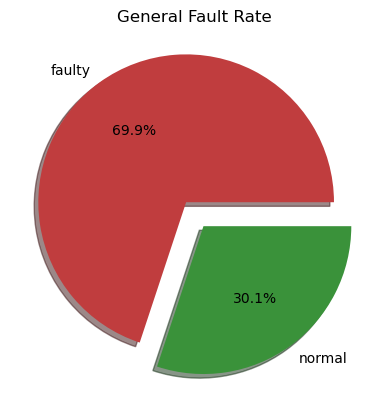

In [66]:
cmap = ["#3274a1", "#e1812c", "#3a923a", "#c03d3e", "#857aab", "#8d7866"]
plt.pie(x = no_faults, 
        explode = [0.1, 0.1],
        labels = ["faulty", "normal"],
        colors = ["#c03d3e", "#3a923a"],
        autopct = "%.1f%%", 
        shadow = True)
plt.title("General Fault Rate");

5496 of 7861 observations(69.9%) in the data set are faulty.


In [67]:
# Second we want to seperate ground and phase faults
gnd_faults = df["G"].value_counts()
gnd_faults

G
0    4465
1    3396
Name: count, dtype: int64

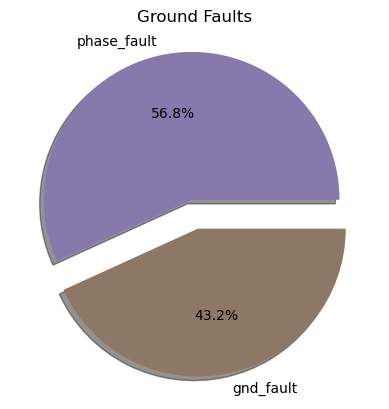

In [68]:
plt.pie(x = gnd_faults, 
        explode = [0.1, 0.1],
        labels = ["phase_fault", "gnd_fault"],
        colors = ["#857aab", "#8d7866"],
        autopct = "%.1f%%", 
        shadow = True)
plt.title("Ground Faults");

3396 of 7861 observations(43.2%) in the data set are ground faults.

In [69]:
# For detailed fault types we represent faults in one fault type column: FType, 
# which we will use it as a target column later.
df["FType"] = df["G"].astype("str") + df["C"].astype("str") + df["B"].astype("str") + df["A"].astype("str")
df

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,FType
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1001
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1001
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1001
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1001
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1001
...,...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598,0000
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407,0000
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104,0000
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690,0000


In [70]:
# Replacing fault types as given fault names for easy visualization
df["FType"][df["FType"] == "0000"] = "NO_Fault"
df["FType"][df["FType"] == "1001"] = "LG_Fault(A-G)"
df["FType"][df["FType"] == "0110"] = "LL_Fault(B-C)"
df["FType"][df["FType"] == "1011"] = "LLG_Fault(A-B-G)"
df["FType"][df["FType"] == "0111"] = "LLL_Fault(A-B-C)"
df["FType"][df["FType"] == "1111"] = "LLLG_Fault(A-B-C-G)"

In [71]:
fault_types = df["FType"].value_counts()
fault_types

FType
NO_Fault               2365
LLG_Fault(A-B-G)       1134
LLLG_Fault(A-B-C-G)    1133
LG_Fault(A-G)          1129
LLL_Fault(A-B-C)       1096
LL_Fault(B-C)          1004
Name: count, dtype: int64

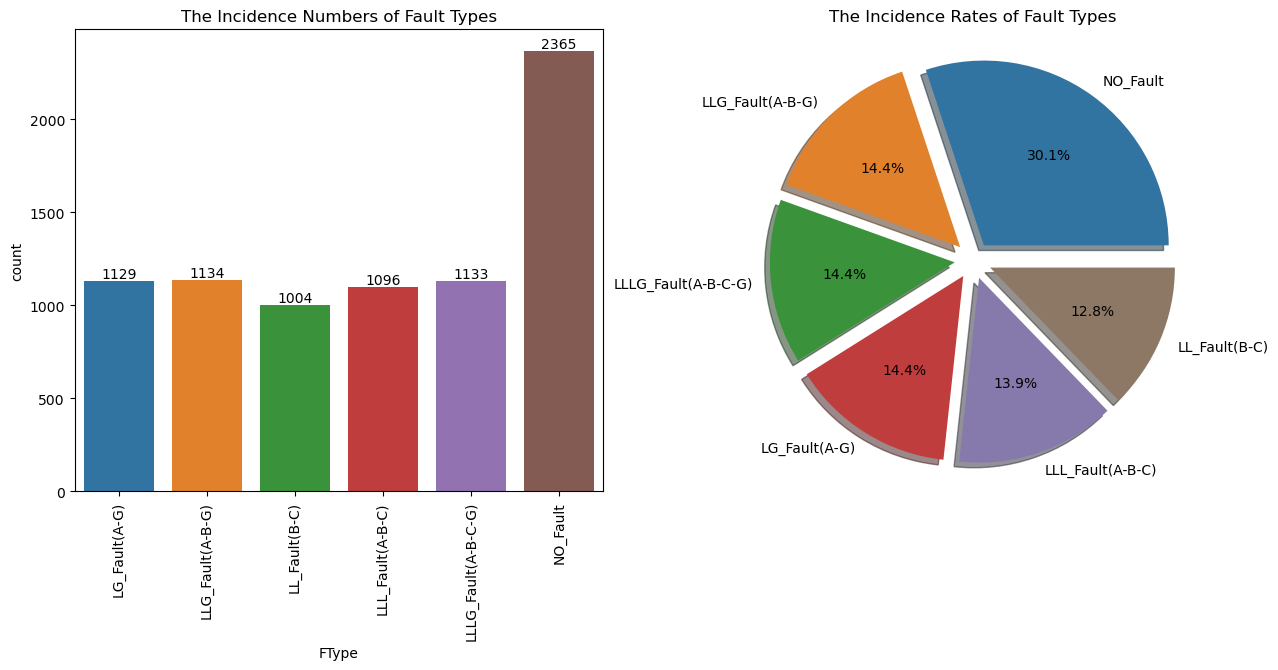

In [72]:
plt.figure(figsize = (15, 6))
plt.subplot(121)
ax = sns.countplot(data = df, x = "FType")
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90)
plt.title("The Incidence Numbers of Fault Types");

plt.subplot(122)
plt.pie(x = fault_types, 
        explode = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        labels = fault_types.index,
        colors = cmap,
        autopct = "%.1f%%", 
        shadow = True)
plt.title("The Incidence Rates of Fault Types");

The incidence rates and numbers of fault types in the data are as above.

#### 2.5.General description of data (count, mean, std, min, max and quartiles)

In [73]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
G,7861.0,0.432006,0.495387,0.000000,0.000000,0.000000,1.000000,1.000000
C,7861.0,0.411271,0.492095,0.000000,0.000000,0.000000,1.000000,1.000000
B,7861.0,0.555527,0.496939,0.000000,0.000000,1.000000,1.000000,1.000000
A,7861.0,0.571429,0.494903,0.000000,0.000000,1.000000,1.000000,1.000000
Ia,7861.0,13.721194,464.741671,-883.542316,-119.802518,2.042805,227.246377,885.738571
Ib,7861.0,-44.845268,439.269195,-900.526951,-271.845947,5.513317,91.194282,889.868884
Ic,7861.0,34.392394,371.107412,-883.357762,-61.034219,-4.326711,49.115141,901.274261
Va,7861.0,-0.007667,0.289150,-0.620748,-0.130287,-0.005290,0.111627,0.595342
Vb,7861.0,0.001152,0.313437,-0.608016,-0.159507,0.001620,0.153507,0.627875
Vc,7861.0,0.006515,0.307897,-0.612709,-0.215977,0.009281,0.239973,0.600179


The reason why the standard deviation is so big is negative values. It increases the variance of the values significantly.

#### 2.6.Distribution of features

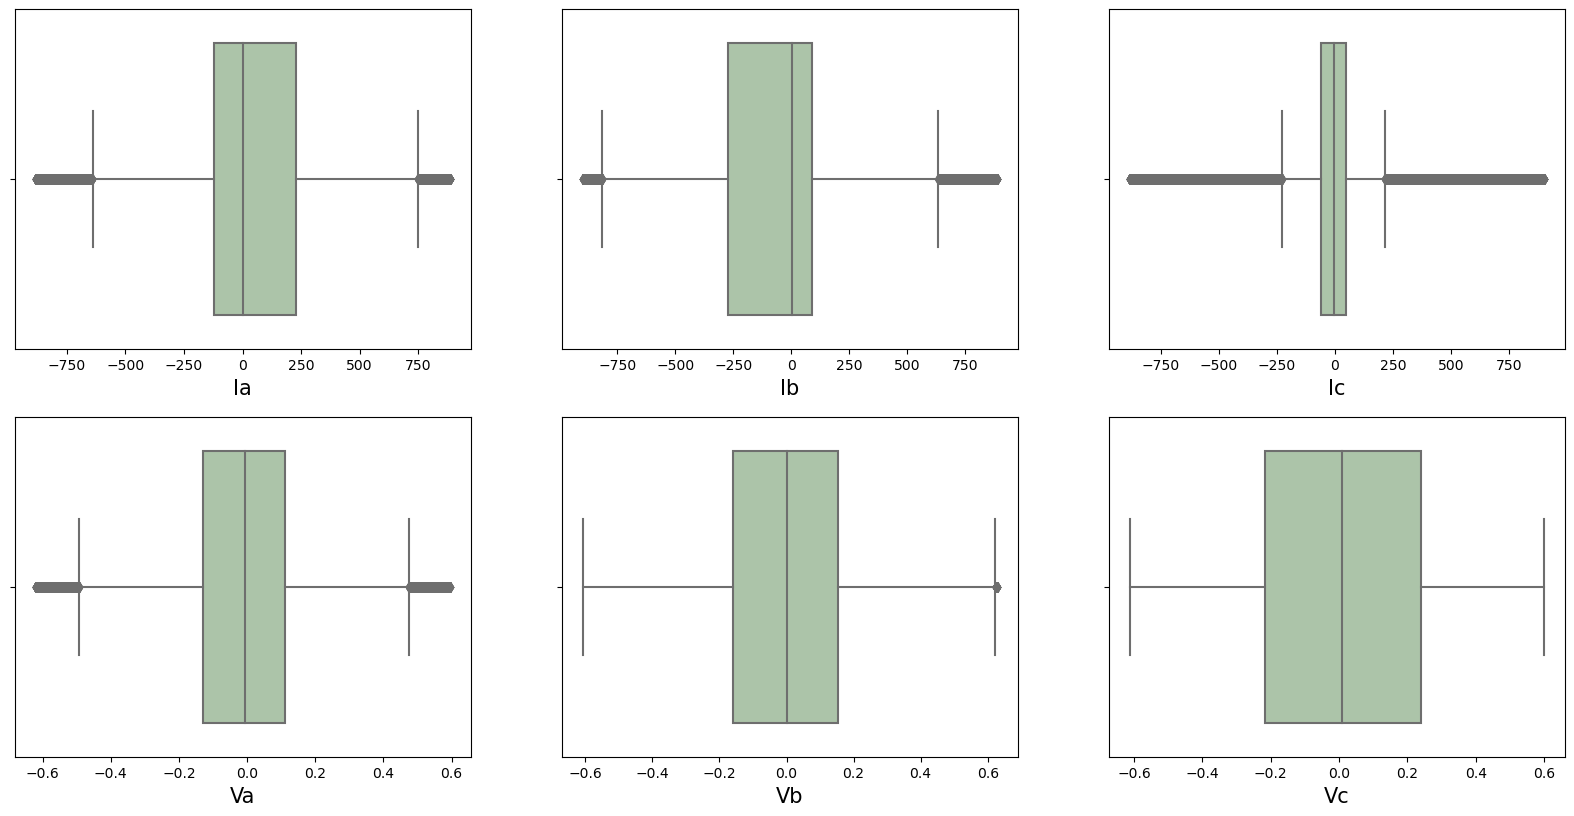

In [74]:
# Distribution by lines (vertical)

plt.figure(figsize = (20, 15))
for i, col in enumerate(df.iloc[:, 4:10]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data = df.iloc[:, 4:10], x = col, color = "#a9c9a4")
    plt.xlabel(col, fontsize = 15)
    plt.xticks(fontsize = 10)

Looks like all the data is somewhat normally distrubuted. Let's have a look a little bit closer.

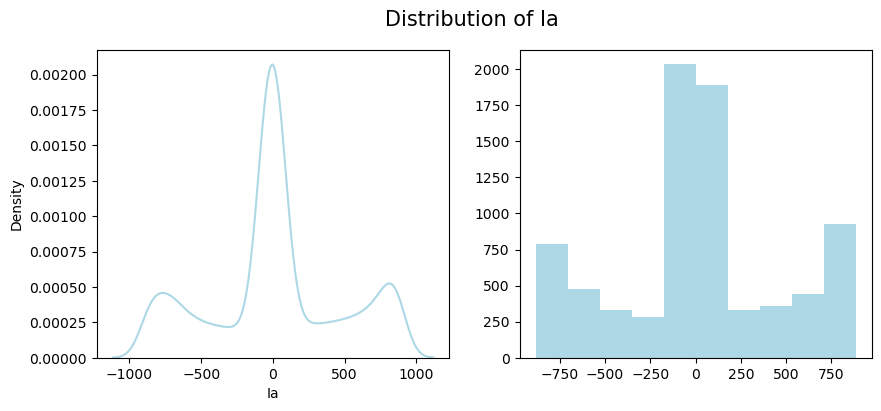

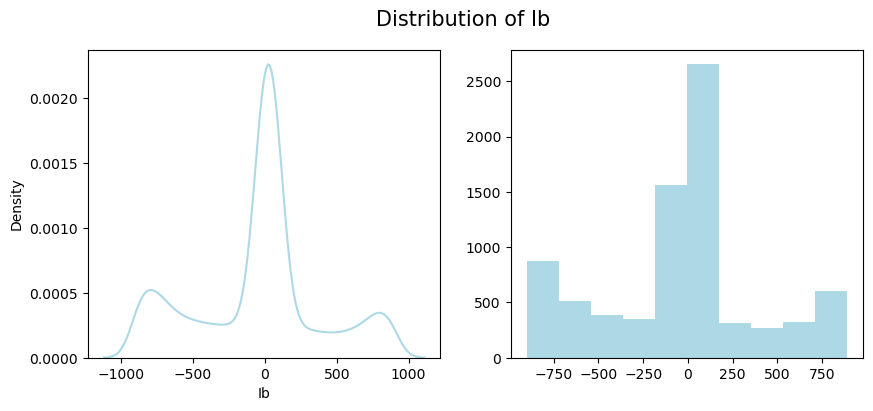

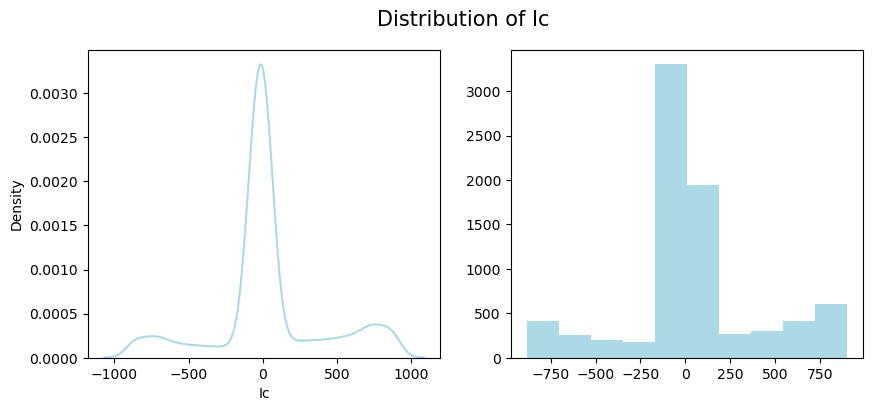

In [75]:
# General distribution of currents
for i, j in enumerate(df.columns[4:7]):
    
    plt.subplots(1, 2, figsize = (10, 4))
    plt.subplot(121)
    sns.kdeplot(x = df[j], color = "lightblue")
    plt.suptitle(f"Distribution of {j}\n", fontsize = 15)

    plt.subplot(122) 
    plt.hist(x = df[j], color = "lightblue")
    plt.show()

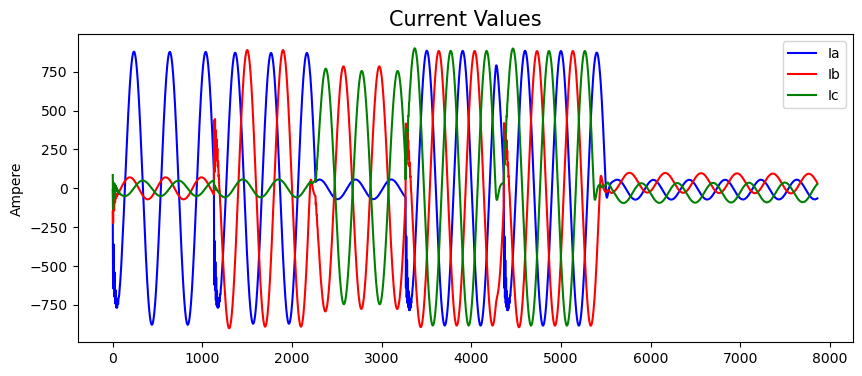

In [76]:
# Plotting all current values in one graph
plt.figure(figsize = (10, 4))
plt.plot(df["Ia"], color = "blue", label = "Ia")
plt.plot(df["Ib"], color = "red", label = "Ib")
plt.plot(df["Ic"], color = "green", label = "Ic")
plt.title("Current Values", fontsize = 15)
plt.ylabel("Ampere")
plt.legend(bbox_to_anchor = (1, 1), loc = "best");

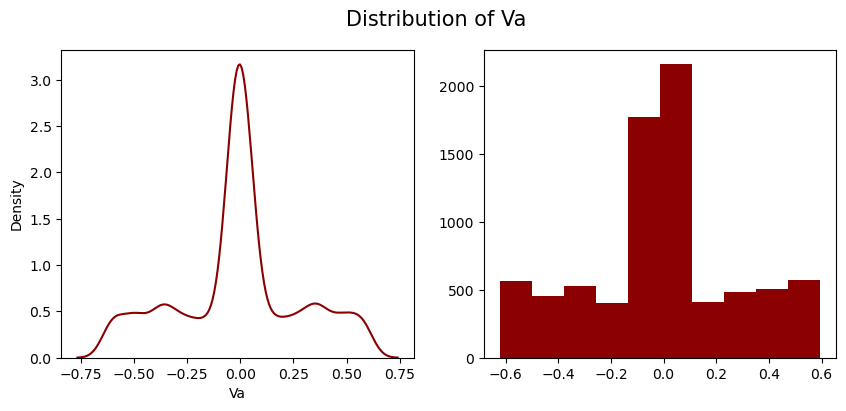

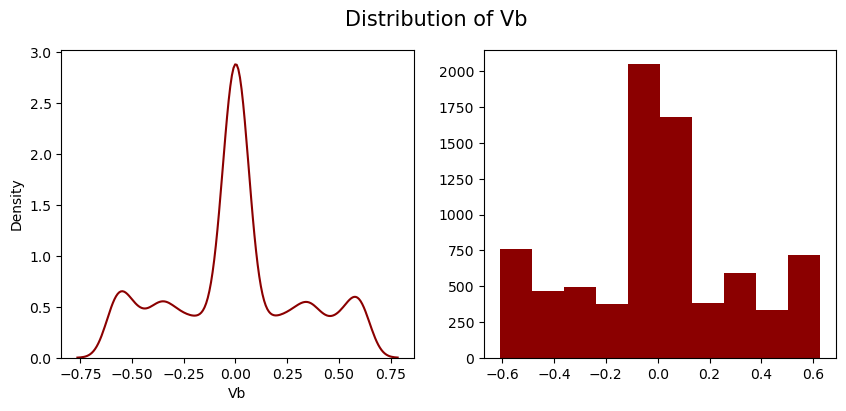

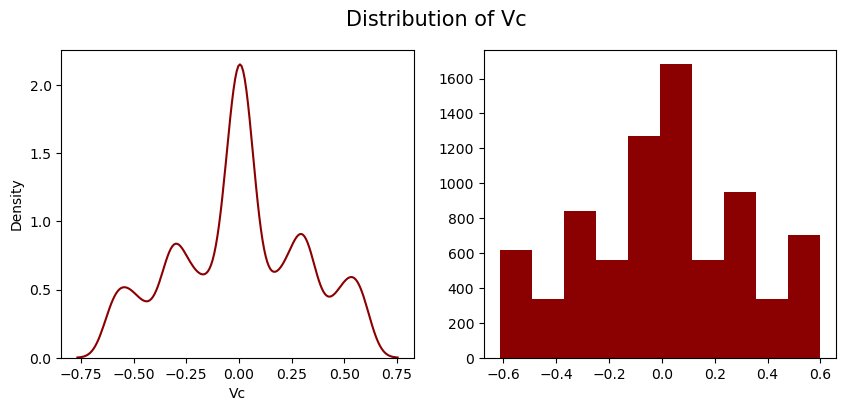

In [77]:
# General distribution of voltages
for i, j in enumerate(df.columns[7:10]):
    
    plt.subplots(1, 2, figsize = (10, 4))
    plt.subplot(121)
    sns.kdeplot(x = df[j], color = "darkred")
    plt.suptitle(f"Distribution of {j}\n", fontsize = 15)

    plt.subplot(122) 
    plt.hist(x = df[j], color = "darkred")
    plt.show()

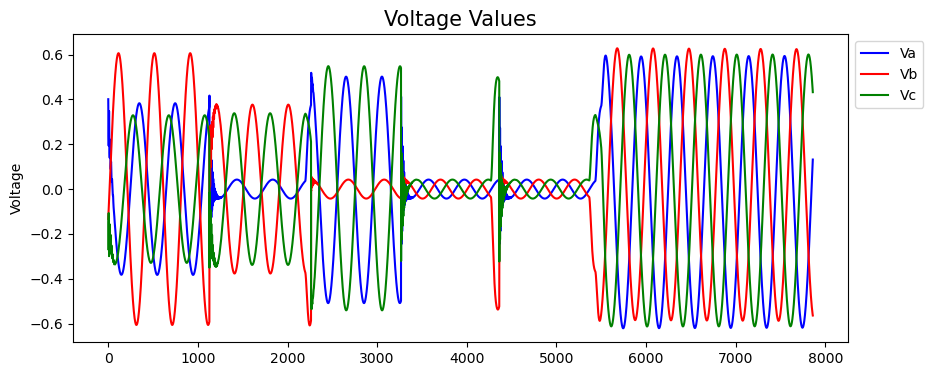

In [78]:
# Plotting all voltage values in one graph
plt.figure(figsize = (10, 4))
plt.plot(df["Va"], color = "blue", label = "Va")
plt.plot(df["Vb"], color = "red", label = "Vb")
plt.plot(df["Vc"], color = "green", label = "Vc")
plt.title("Voltage Values", fontsize = 15)
plt.ylabel("Voltage")
plt.legend(bbox_to_anchor = (1, 1), loc = "best");

The large fluctuations in current and voltage graphs indicate faults. But we don't know which fluctation represents which fault type.

#### 2.7.Fault types by features

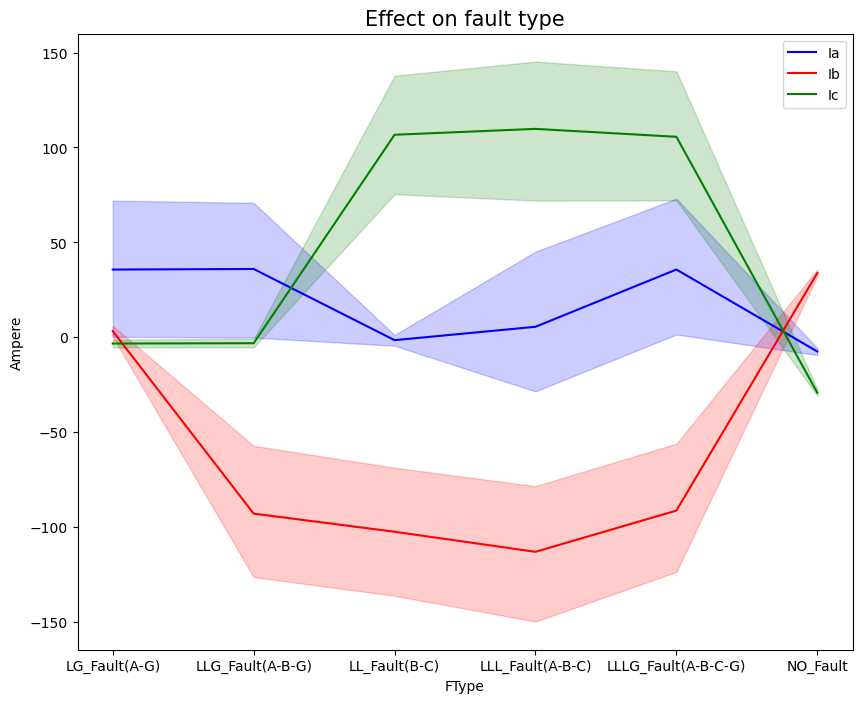

In [79]:
# The effect of currents on the fault types
plt.figure(figsize = (10, 8))
sns.lineplot(data = df, x = "FType", y = "Ia", label = "Ia", color = "blue")
sns.lineplot(data = df, x = "FType", y = "Ib", label = "Ib", color = "red")
sns.lineplot(data = df, x = "FType", y = "Ic", label = "Ic", color = "green")
plt.ylabel("Ampere")
plt.title("Effect on fault type", fontsize = 15)
plt.legend(bbox_to_anchor = (1, 1), loc = "best")
plt.show()

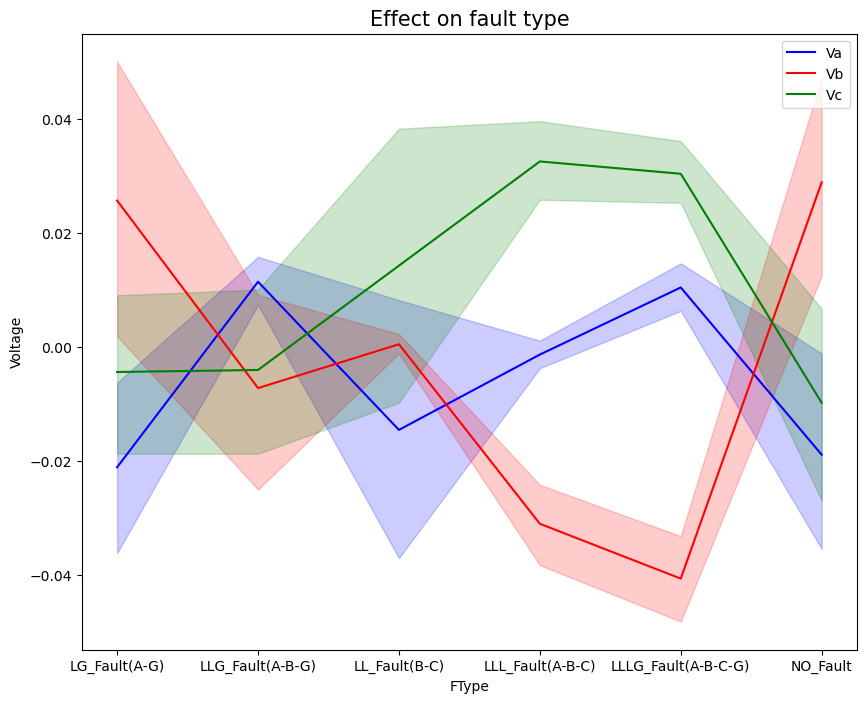

In [80]:
# The effect of voltages on the fault types
plt.figure(figsize = (10, 8))
sns.lineplot(data = df, x = "FType", y = "Va", label = "Va", color = "blue")
sns.lineplot(data = df, x = "FType", y = "Vb", label = "Vb", color = "red")
sns.lineplot(data = df, x = "FType", y = "Vc", label = "Vc", color = "green")
plt.ylabel("Voltage")
plt.title("Effect on fault type", fontsize = 15)
plt.legend(bbox_to_anchor = (1, 1), loc = "best")
plt.show()

Now we know the current and voltage values for fault types. For instance now we know for LG_Fault(A-G) there is a current value on Ia. Similarly, for LLL_Fault(A-B-C) there are current values on Ia, Ib and Ic. For NO_Fault there aren't any current values. So, we can say that now if we see a current value in a line, then there is a fault. 

#### 2.8.Features by fault types

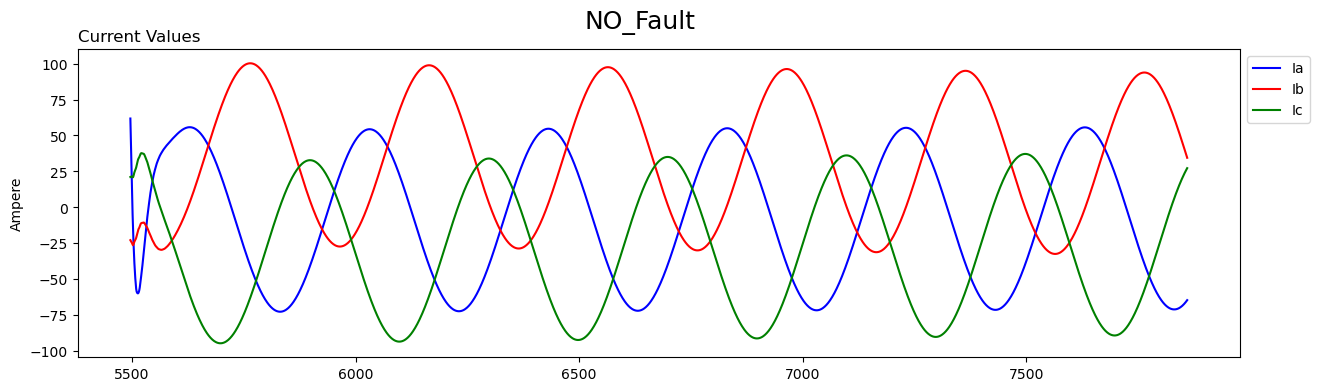

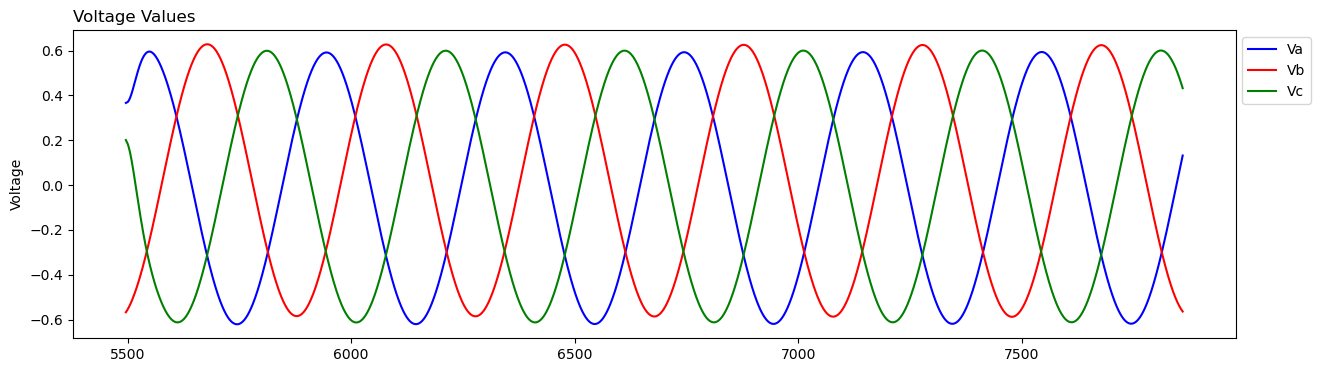

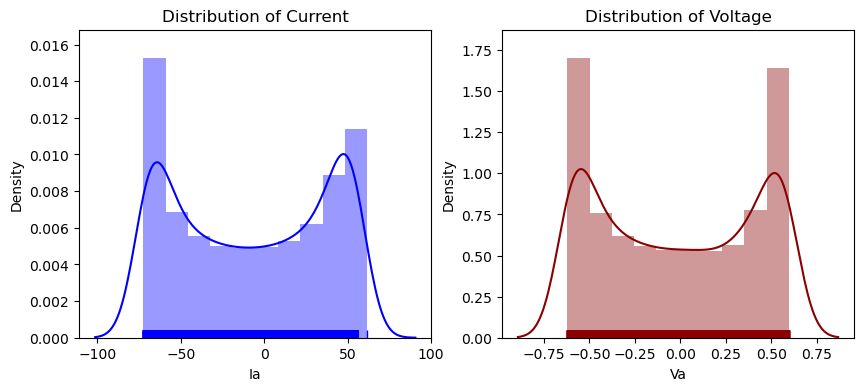

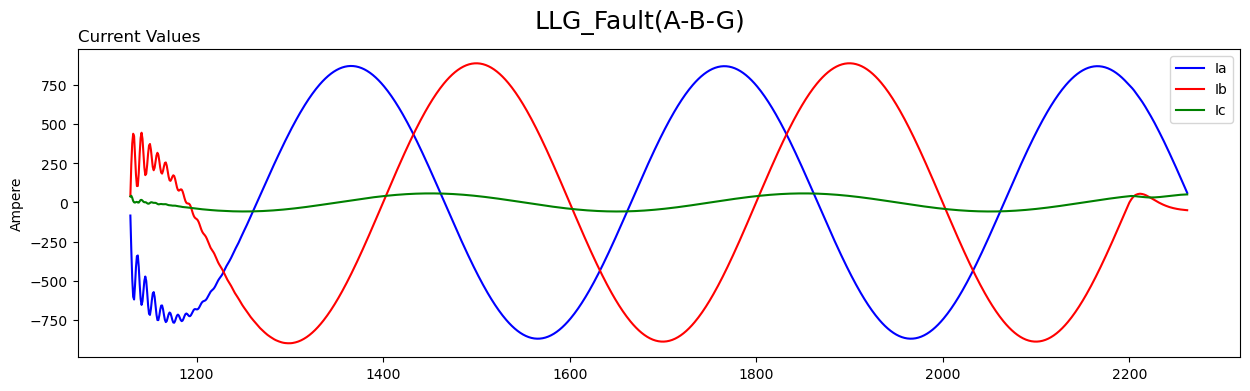

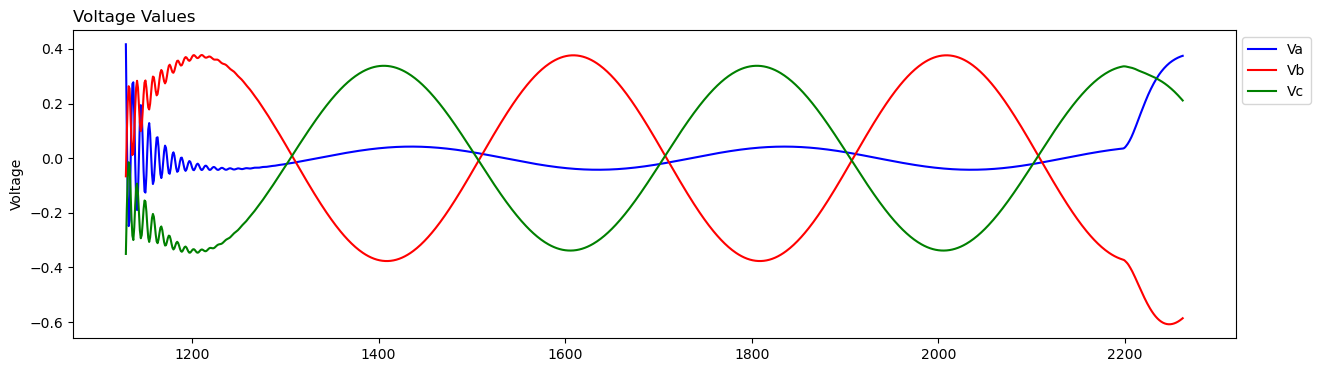

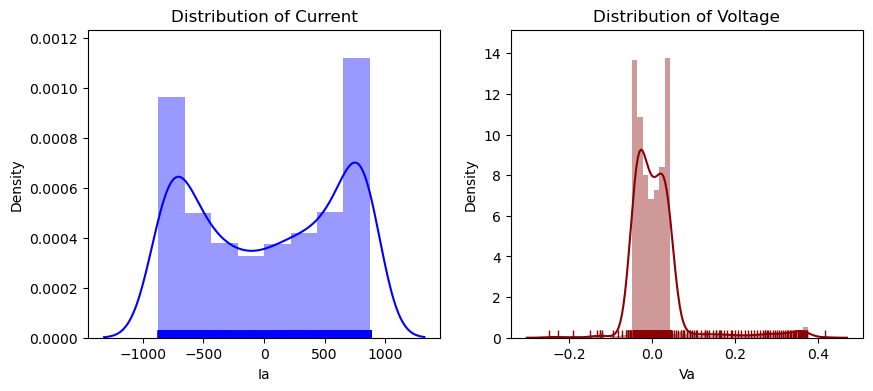

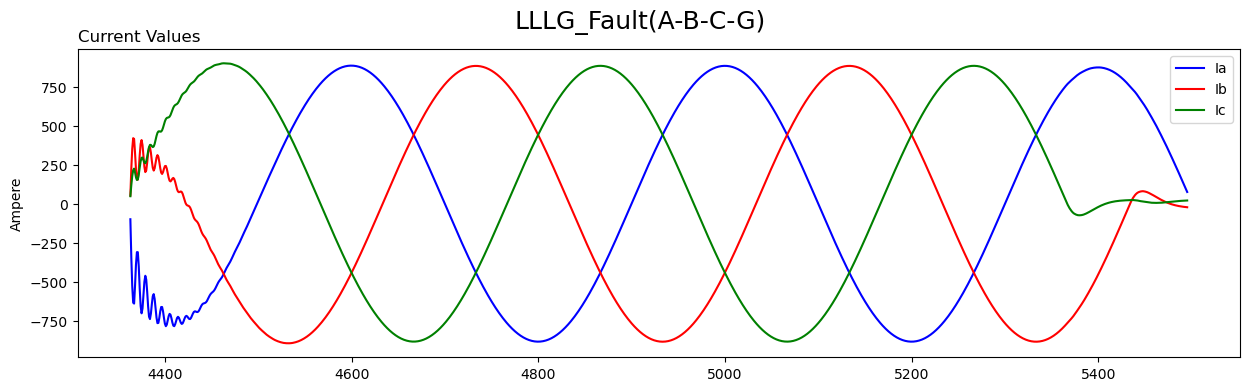

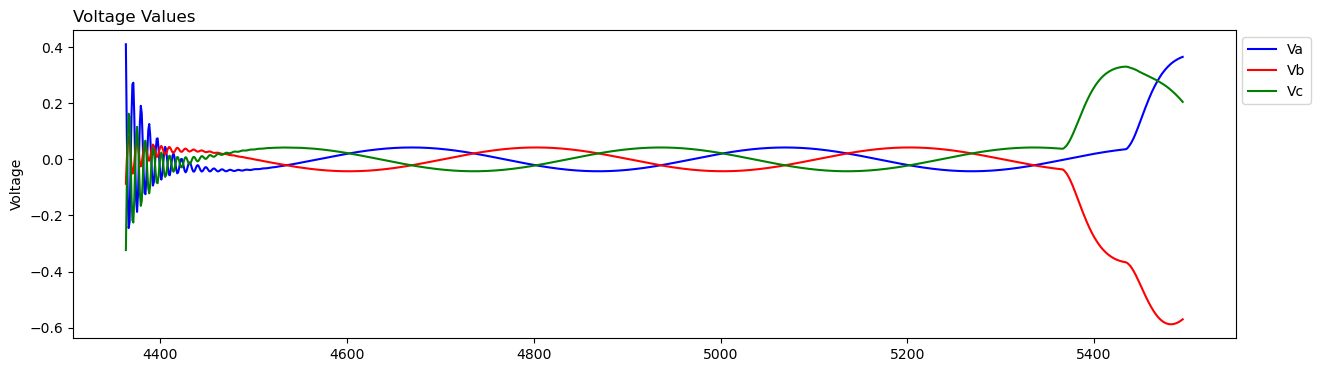

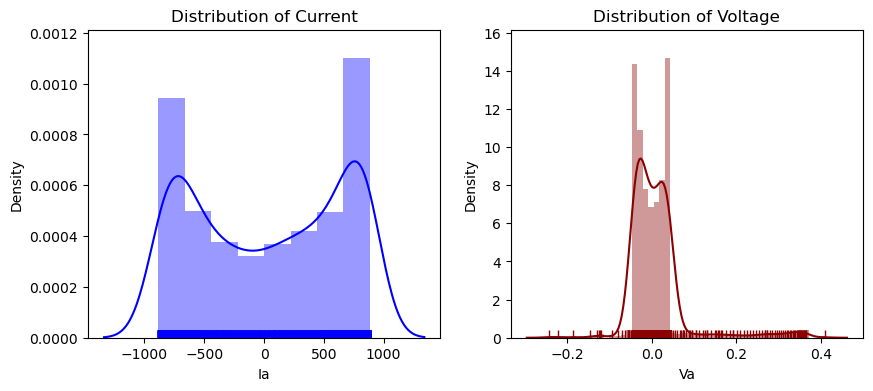

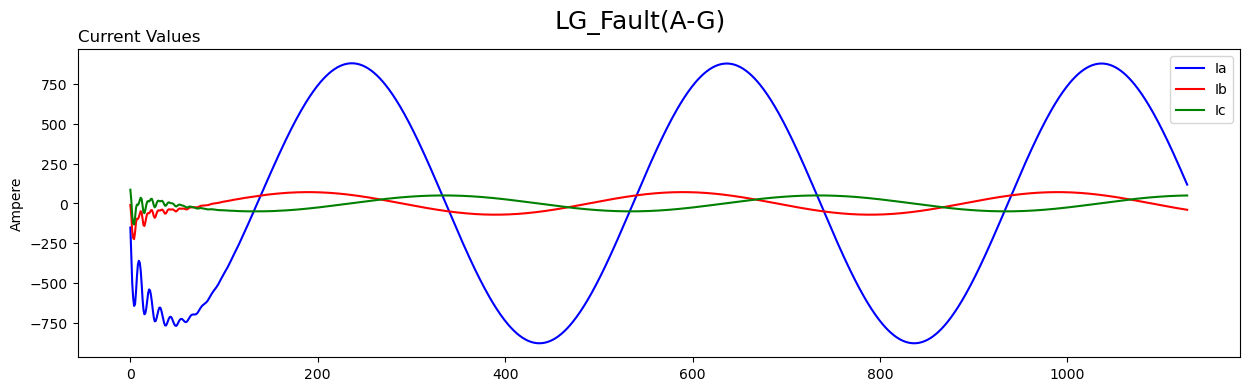

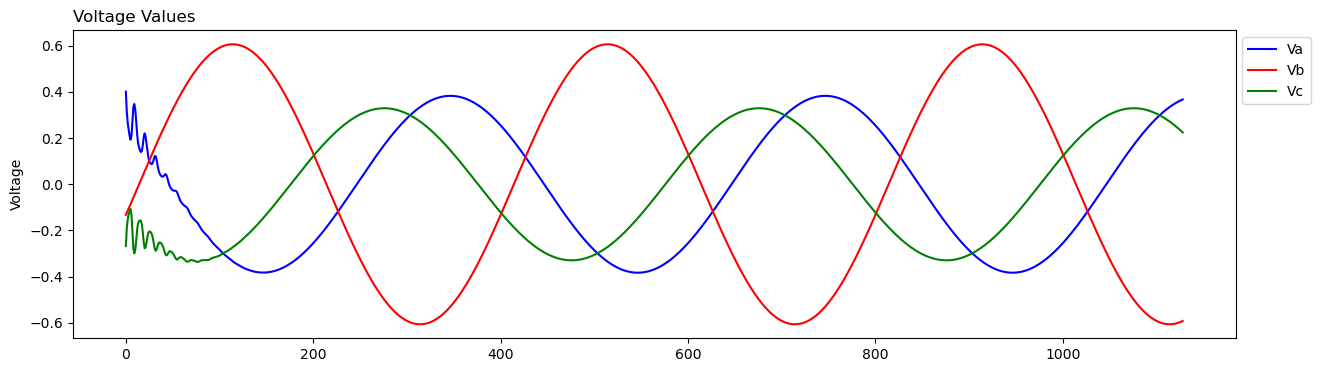

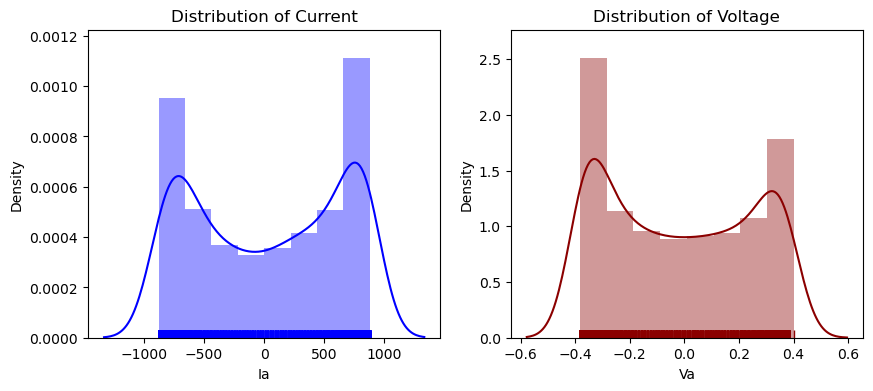

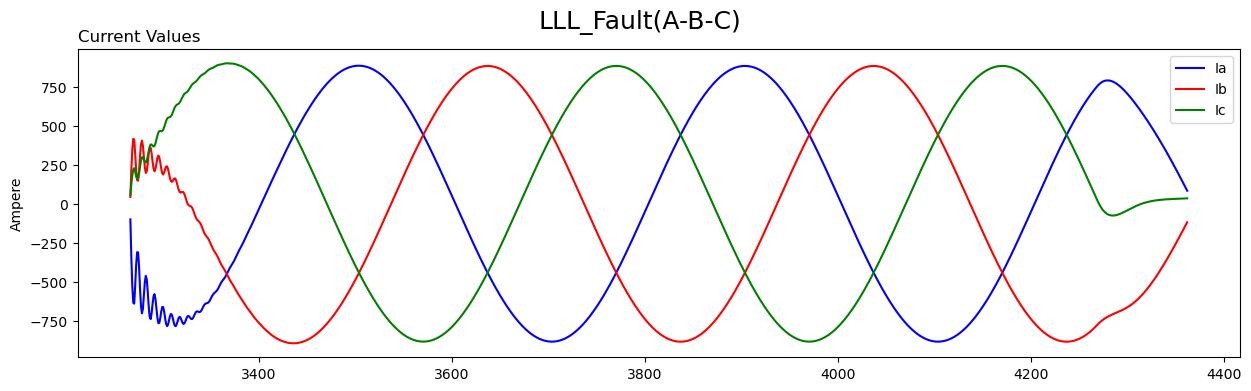

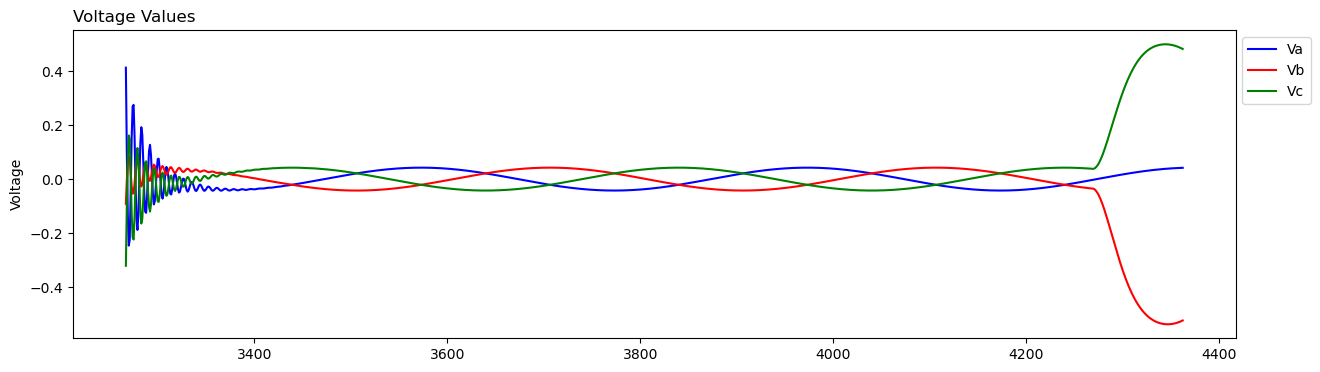

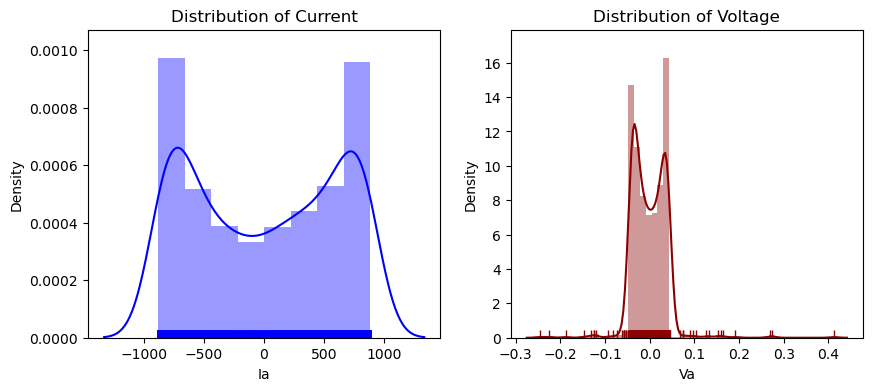

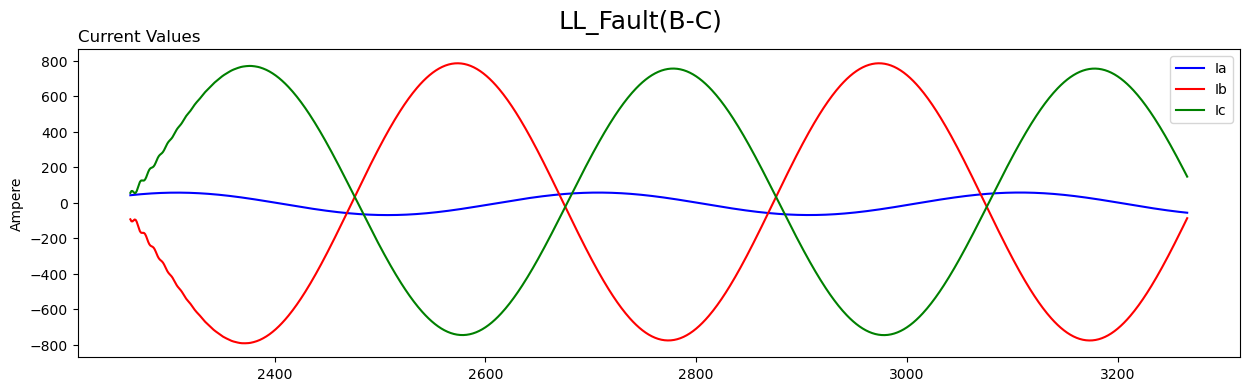

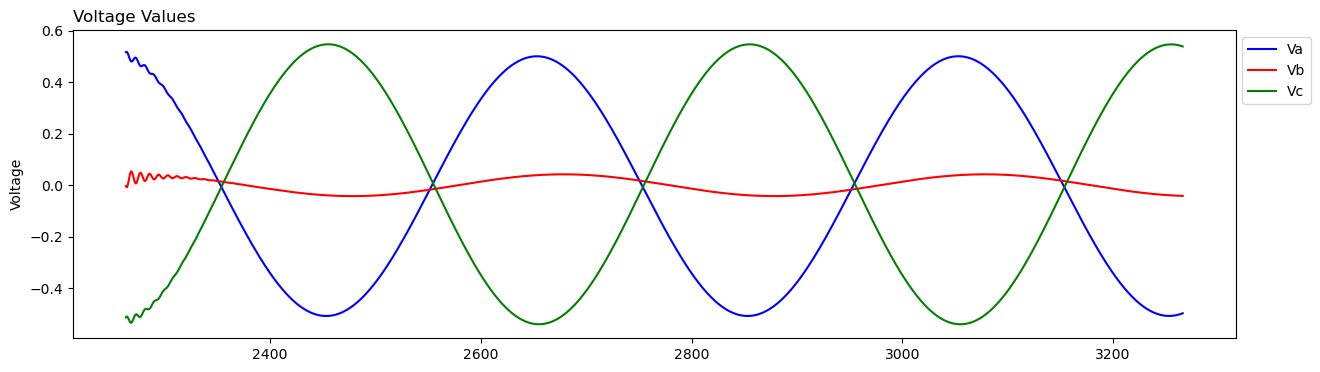

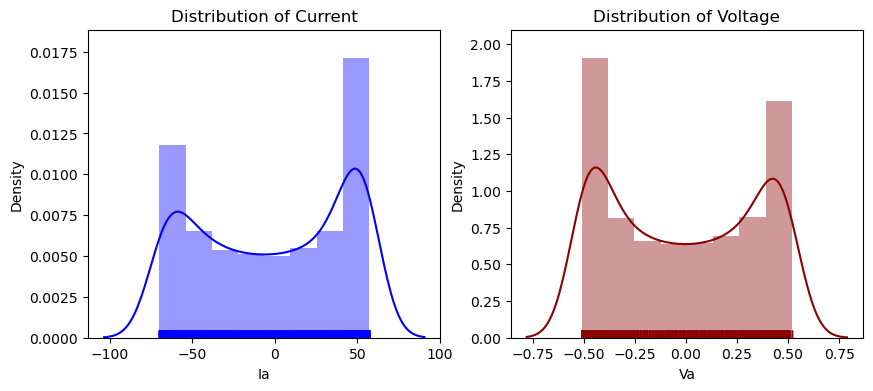

In [81]:
fault_list = {"0000": "NO_Fault", 
              "1011": "LLG_Fault(A-B-G)", 
              "1111": "LLLG_Fault(A-B-C-G)", 
              "1001": "LG_Fault(A-G)",
              "0111": "LLL_Fault(A-B-C)",
              "0110": "LL_Fault(B-C)"}

for i in fault_list.values():
    
    # Current values
    plt.figure(figsize = (15, 4))
    plt.plot(df[df["FType"] == i]["Ia"], color = "blue", label = "Ia")
    plt.plot(df[df["FType"] == i]["Ib"], color = "red", label = "Ib")
    plt.plot(df[df["FType"] == i]["Ic"], color = "green", label = "Ic")
    plt.ylabel("Ampere")
    plt.title("Current Values", loc = "left")
    plt.suptitle(f"{i}\n", fontsize = 18)
    plt.legend(bbox_to_anchor = (1, 1), loc = "best");

    # Voltage values
    plt.figure(figsize = (15, 4))
    plt.plot(df[df["FType"] == i]["Va"], color = "blue", label = "Va")
    plt.plot(df[df["FType"] == i]["Vb"], color = "red", label = "Vb")
    plt.plot(df[df["FType"] == i]["Vc"], color = "green", label = "Vc")
    plt.ylabel("Voltage")
    plt.title("Voltage Values", loc = "left")
    plt.legend(bbox_to_anchor = (1, 1), loc = "best");

    # Comparison of current and voltage distiributions
    plt.figure(figsize = (10, 4))

    plt.subplot(121)
    sns.distplot(df[df["FType"] == i]["Ia"], color = "blue", rug = True, kde = True)
    plt.xlabel("Ia")
    plt.title("Distribution of Current");

    plt.subplot(122)
    sns.distplot(df[df["FType"] == i]["Va"], color = "darkred", rug = True, kde = True)
    plt.xlabel("Va")
    plt.title("Distribution of Voltage");

In NO_Fault condition current and voltage curves are symmetrical and sinusoidal as they are supposed to be.

In LLG_Fault(A-B-G) condition there appear to be some distortions on current and voltage curves. The current values in A and B line increase above 750 ampere. The assymmetry on the final parts of voltage curves is striking. Similarly, the disorder on the distribution curves between Ia and Va stand out.

Likewise, in LLLG_Fault(A-B-C-G) condition there appear to be some distortions on current and voltage curves. The current values in all lines increase above 750 ampere. The assymmetry on the final parts of voltage curves is striking. Similarly, the disorder on the distribution curves between Ia and Va stand out.

In LG_Fault(A-G) condition there appear to be some distortions on current and voltage curves. The current values in A line increase above 750 ampere. The assymmetry on voltage curves is striking. There is an opposition on the distribution curves between Ia and Va stand out. The curves are opposites of each other.

In LLL_Fault(A-B-C) condition there appear to be some distortions on current and voltage curves. The current values in all lines increase above 750 ampere. The assymmetry on the final parts of voltage curves is striking. Similarly, the disorder on the distribution curves between Ia and Va stand out.

In LL_Fault(B-C) condition there appear to be some distortions on current and voltage curves. The current values in B and C lines increase above 750 ampere.


#### 2.9.Encoding categorical features

In [82]:
df["FType"] = df["FType"].astype("category")

In [83]:
df["FType"] = df["FType"].cat.codes
df

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,FType
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,0
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,0
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,0
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,0
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,0
...,...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598,5
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407,5
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104,5
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690,5


In [84]:
fault_types2 = df["FType"].value_counts()
fault_types2

FType
5    2365
1    1134
2    1133
0    1129
3    1096
4    1004
Name: count, dtype: int64

##### 2.9.1.Coding table

In [85]:
# First we transform the fault type series into dataframes
fault_types2_df = pd.DataFrame(fault_types2)
fault_types2_df.reset_index(level = 0, inplace = True)
fault_types2_df = fault_types2_df.rename(columns = {"FType":"index", "count":"FType"})
fault_types2_df

,index,FType
0,5,2365
1,1,1134
2,2,1133
3,0,1129
4,3,1096
5,4,1004


In [86]:
fault_types

FType
NO_Fault               2365
LLG_Fault(A-B-G)       1134
LLLG_Fault(A-B-C-G)    1133
LG_Fault(A-G)          1129
LLL_Fault(A-B-C)       1096
LL_Fault(B-C)          1004
Name: count, dtype: int64

In [87]:
fault_types_df = pd.DataFrame(fault_types)
fault_types_df.reset_index(level = 0, inplace = True)
fault_types_df = fault_types_df.rename(columns = {"FType":"index", "count":"FType"})
fault_types_df

,index,FType
0,NO_Fault,2365
1,LLG_Fault(A-B-G),1134
2,LLLG_Fault(A-B-C-G),1133
3,LG_Fault(A-G),1129
4,LLL_Fault(A-B-C),1096
5,LL_Fault(B-C),1004


In [88]:
# Then we merge fault types dataframes amd create the table
code_table = fault_types2_df.merge(fault_types_df, how = "left", on = "FType")
code_table = code_table.rename(columns = {"index_x":"Codes", "FType":"Number", "index_y":"FaultType"})
code_table = code_table.reindex(columns = ["Codes", "FaultType", "Number"])
code_table = code_table.set_index("Codes")
code_table = code_table.sort_index()
code_table

,FaultType,Number
Codes,,
0,LG_Fault(A-G),1129
1,LLG_Fault(A-B-G),1134
2,LLLG_Fault(A-B-C-G),1133
3,LLL_Fault(A-B-C),1096
4,LL_Fault(B-C),1004
5,NO_Fault,2365


In [89]:
# We represent (G, C, B, A) columns as one column FType, so we can drop them.
df = df.drop(["G", "C", "B", "A"], axis = 1)
df

,Ia,Ib,Ic,Va,Vb,Vc,FType
0,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,0
1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,0
2,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,0
3,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,0
4,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,0
...,...,...,...,...,...,...,...
7856,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598,5
7857,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407,5
7858,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104,5
7859,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690,5


#### 2.10.Feature Correlations

In [90]:
df.corr()

,Ia,Ib,Ic,Va,Vb,Vc,FType
Ia,1.000000,-0.374241,-0.276457,0.035682,-0.274612,0.246043,-0.039834
Ib,-0.374241,1.000000,-0.528291,0.029118,0.032101,-0.060023,0.049736
Ic,-0.276457,-0.528291,1.000000,-0.069137,-0.056967,0.122919,-0.018092
Va,0.035682,0.029118,-0.069137,1.000000,-0.480247,-0.450225,-0.018895
Vb,-0.274612,0.032101,-0.056967,-0.480247,1.000000,-0.566986,0.025316
Vc,0.246043,-0.060023,0.122919,-0.450225,-0.566986,1.000000,-0.008027
FType,-0.039834,0.049736,-0.018092,-0.018895,0.025316,-0.008027,1.000000


(7.5, -0.5)

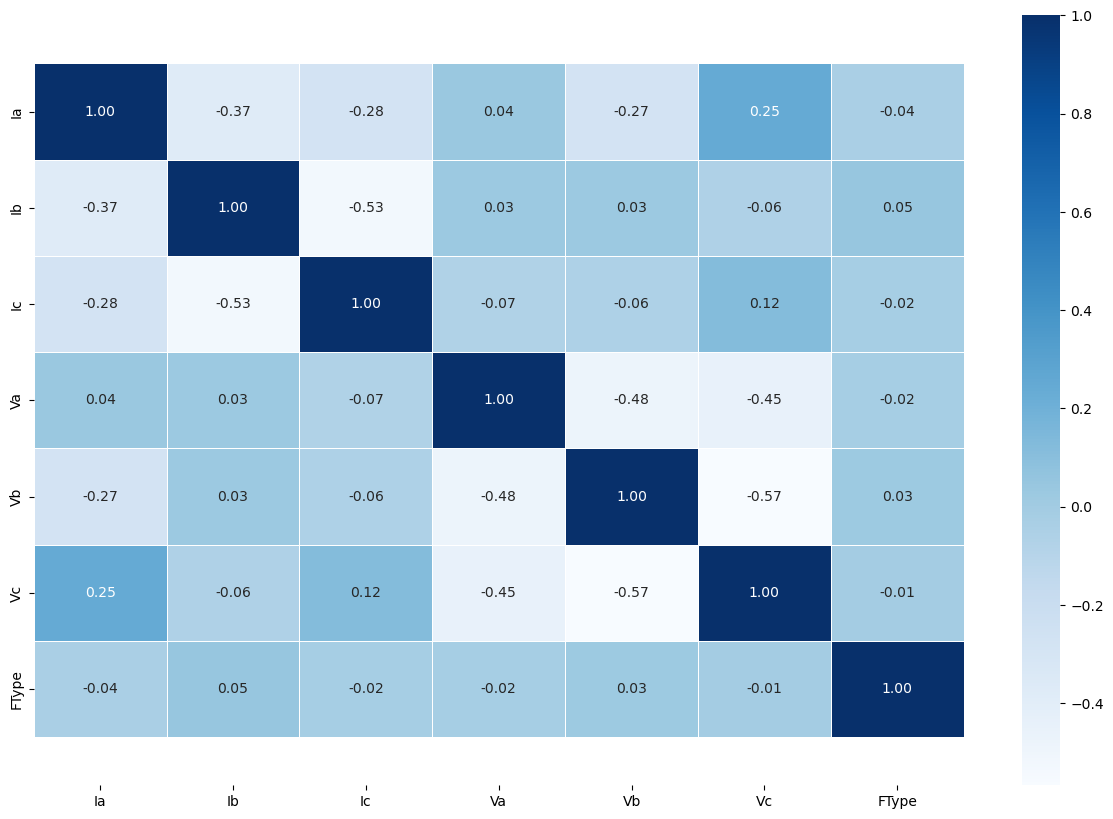

In [91]:
# Correlation matrix
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.heatmap(corr_matrix,
                 annot = True,
                 linewidths = 0.5,
                 fmt = ".2f",
                 cmap = "Blues");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

The correlation matrix indicates the features are independent and not correlated with each other.

### 3.Data preprocessing

#### 3.1.Splitting

In [92]:
#Split data into X and y
X = df.drop(["FType"], axis = 1)
y = df["FType"]

In [93]:
X

,Ia,Ib,Ic,Va,Vb,Vc
0,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983
...,...,...,...,...,...,...
7856,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598
7857,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407
7858,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104
7859,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690


In [94]:
y

0       0
1       0
2       0
3       0
4       0
       ..
7856    5
7857    5
7858    5
7859    5
7860    5
Name: FType, Length: 7861, dtype: int8

In [95]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = seed)

#### 3.2.Standardization

In [96]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_trainStandart = scaler.transform(X_train)
X_testStandart = scaler.transform(X_test)

In [97]:
X_trainStandart, len(X_trainStandart)

(array([[ 0.45594267,  1.51262288,  0.06828224,  0.17518898, -0.97703383,
          0.83192725],
        [ 0.85209968,  1.17610392, -2.46872351,  0.17872116, -0.07564884,
         -0.0917635 ],
        [-0.12160575,  1.88147271, -2.08148889,  0.4511635 , -0.02777978,
         -0.3982693 ],
        ...,
        [-1.87817186,  1.38820665, -0.10022439, -0.01448486,  0.80537048,
         -0.8086186 ],
        [-0.18626679,  0.26020373, -0.08696886, -0.52754779, -1.3288756 ,
          1.85570068],
        [ 1.81307252, -0.60188459, -0.07006873,  0.12197778, -1.04982613,
          0.95656922]]),
 5895)

In [98]:
X_testStandart, len(X_testStandart)

(array([[ 1.06194583,  0.20918997, -0.07244335,  0.83533209, -1.68306403,
          0.92856178],
        [ 1.39364807,  0.12349708,  0.00413926,  0.73255241, -1.70187502,
          1.04496008],
        [ 1.80322392, -0.42859231, -1.76226928,  0.13075998, -0.13995289,
          0.01924705],
        ...,
        [ 0.03514251, -1.66664535,  1.9359587 , -0.09428866, -0.00698134,
          0.09629039],
        [ 1.05562983,  0.95504439, -2.46185859,  0.1775723 , -0.08979858,
         -0.07622965],
        [ 0.04576701,  0.22252398, -0.33429328, -1.14293949,  1.99184014,
         -0.95295203]]),
 1966)

### 4.Modelling

#### 4.1.Classifier comparison with default parameters

In [99]:
scoresCV = []
classifiers = [KNeighborsClassifier(),
               LogisticRegression(random_state = seed),
               RandomForestClassifier(random_state = seed), 
               GradientBoostingClassifier(random_state = seed),
               DecisionTreeClassifier(random_state = seed),
               SVC(random_state = seed),
               XGBClassifier(random_state = seed)
              ]

for classifier in classifiers:
    pipe = make_pipeline(preprocessing.StandardScaler(), classifier)
    scoreCV = cross_val_score(pipe, 
                              X_train, 
                              y_train, 
                              scoring = "accuracy", 
                              cv = StratifiedKFold(n_splits = 5, 
                                                   shuffle = True,
                                                   random_state = seed))
    scoresCV.append([classifier, np.mean(scoreCV)])

In [100]:
# Best classifiers according to validation accuracy descending
c_val = pd.DataFrame(scoresCV, columns=["Classifier", "Validation Accuracy"])
c_val_sort = c_val.sort_values(by = "Validation Accuracy", ignore_index = True)
c_val_sort

,Classifier,Validation Accuracy
0,LogisticRegression(random_state=20),0.354538
1,SVC(random_state=20),0.805428
2,"XGBClassifier(base_score=None, booster=None, c...",0.822222
3,KNeighborsClassifier(),0.827481
4,GradientBoostingClassifier(random_state=20),0.841730
5,RandomForestClassifier(random_state=20),0.856149
6,DecisionTreeClassifier(random_state=20),0.860221


#### 4.2.Logistic Regression Model

##### 4.2.1.Parameter Tuning

In [101]:
# Comparison of C values
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
scoresCV = [] #For appending all cross validation scores

for c in C_param_range:
    logreg = LogisticRegression(C = c,
                                penalty = "l2",
                                max_iter = 1000)
    pipe = make_pipeline(preprocessing.StandardScaler(), logreg)
    scoreCV = cross_val_score(pipe, 
                              X_train, 
                              y_train, 
                              scoring = "accuracy",
                              cv = StratifiedKFold(n_splits = 5, 
                                                   shuffle = True,
                                                   random_state = seed))
    scoresCV.append([c, np.mean(scoreCV)])

In [102]:
c_val_ = pd.DataFrame(scoresCV, columns=["C", "Validation Accuracy"])
c_val_

,C,Validation Accuracy
0,0.001,0.300763
1,0.010,0.314334
2,0.100,0.351654
3,1.000,0.354538
4,10.000,0.355047
5,100.000,0.355386
6,1000.000,0.355386
7,10000.000,0.355386


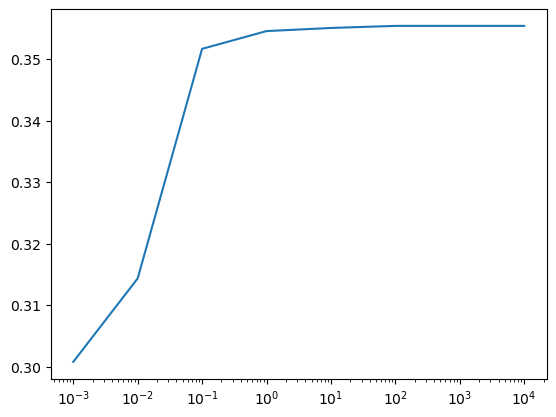

In [103]:
ax = plt.gca()
ax.plot(c_val_["C"].values, c_val_["Validation Accuracy"].values)
ax.set_xscale("log")

Best C value for l2 penalty

In [104]:
# Making pipeline for other parameters and grid search
pipe = Pipeline([("scaler", preprocessing.StandardScaler()),
                 ("Classifier", LogisticRegression(max_iter = 10000, random_state = seed))])

params = [{"Classifier__solver": ["liblinear"], 
           "Classifier__penalty": ["l1", "l2"],
           "Classifier__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]

# Creating grid
lr_clf_grid = GridSearchCV(estimator = pipe,
                           param_grid = params,
                           cv = StratifiedKFold(n_splits = 10, 
                                                shuffle = True,
                                                random_state = seed),
                           refit = True,
                           verbose = 2,
                           scoring = "accuracy")
# Fit the model
lr_model = lr_clf_grid.fit(X_trainStandart, y_train)

# Get best parameters
print("Best parameters for Logistic Regression model: ", lr_model.best_params_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END Classifier__C=0.001, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.0s
[CV] END C

[CV] END Classifier__C=10, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.4s
[CV] END Classifier__C=10, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.2s
[CV] END Classifier__C=10, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.2s
[CV] END Classifier__C=10, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.1s
[CV] END Classifier__C=10, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.5s
[CV] END Classifier__C=10, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.2s
[CV] END Classifier__C=10, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.1s
[CV] END Classifier__C=10, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.2s
[CV] END Classifier__C=10, Classifier__penalty=l1, Classifier__solver=liblinear; total time=   0.3s
[CV] END Classifier__C=10, Classifier__penalty=l2, Classifier__solver=liblinear; total time=   0.0s


In [105]:
lr_best = pd.DataFrame.from_dict(lr_model.best_params_, orient = "index").rename(columns = {0: "Best"})
lr_best

,Best
Classifier__C,100
Classifier__penalty,l1
Classifier__solver,liblinear


##### 4.2.2.Building model with best parameters

In [106]:
lr_clf = LogisticRegression(C = float(lr_best.iloc[0,0]),
                            penalty = lr_best.iloc[1,0],
                            solver = lr_best.iloc[2,0],
                            max_iter = 10000, 
                            random_state = seed)
# Fitting the model
lr_clf.fit(X_train, y_train)

LogisticRegression(C=100.0, max_iter=10000, penalty='l1', random_state=20,
                   solver='liblinear')

4.2.3.Predictions and model accuracy

In [107]:
lr_pred = lr_clf.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)
print("Logistic Regression Model Accuracy:", lr_acc)
lr_acc_tr = lr_clf.score(X_train, y_train)
print("Logistic Regression Training Accuracy:", lr_acc_tr)

Logistic Regression Model Accuracy: 0.35300101729399797
Logistic Regression Training Accuracy: 0.3511450381679389


##### 4.2.4.Other test parameters

In [108]:
# Classification Report
print("Logistic Regression Classification Report\n\n", classification_report(y_test, lr_pred))

Logistic Regression Classification Report

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       282
           1       0.98      0.18      0.31       284
           2       0.46      0.17      0.25       283
           3       0.03      0.00      0.01       274
           4       0.00      0.00      0.00       251
           5       0.33      1.00      0.50       592

    accuracy                           0.35      1966
   macro avg       0.30      0.23      0.18      1966
weighted avg       0.31      0.35      0.23      1966



In [109]:
lr_recall = recall_score(y_test, lr_pred, average = None)
lr_precision = precision_score(y_test, lr_pred, average = None)
lr_f1 = f1_score(y_test, lr_pred, average = None)

Logistic Regression Confusion Matrix


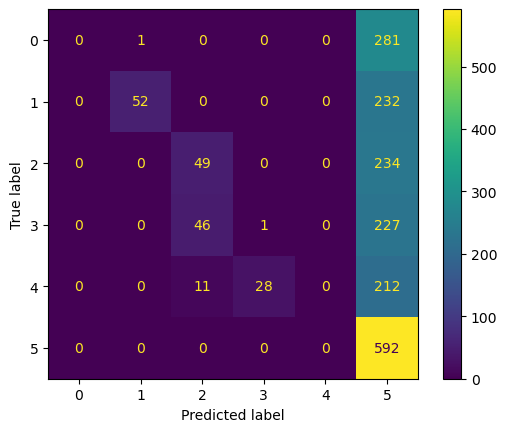

In [110]:
#Confusion matrix
lr_cm = confusion_matrix(y_test, lr_pred, labels = lr_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = lr_cm,
                              display_labels = lr_clf.classes_)
print("Logistic Regression Confusion Matrix")
disp.plot()
plt.show()

In [111]:
# Fault rates
def calculateFaultRates(model_name, acc, cm):
    print(f"""
    The success rate of the {model_name} model on the test set: {(acc*100):.0f}%
    LG_Fault(A-G) correct prediction rate: {((cm[0][0]/sum(cm[0]))*100):.0f}%"
    LLG_Fault(A-B-G) correct prediction rate: {((cm[1][1]/sum(cm[1]))*100):.0f}%"
    LLLG_Fault(A-B-C-G) correct prediction rate: {((cm[2][2]/sum(cm[2]))*100):.0f}%
    LLL_Fault(A-B-C) correct prediction rate: {((cm[3][3]/sum(cm[3]))*100):.0f}%
    LL_Fault(B-C) correct prediction rate: {((cm[4][4]/sum(cm[4]))*100):.0f}%
    NO_Fault correct prediction rate: {((cm[5][5]/sum(cm[5]))*100):.0f}%
    """)

In [112]:
calculateFaultRates("Logistic Regression", lr_acc, lr_cm)


    The success rate of the Logistic Regression model on the test set: 35%
    LG_Fault(A-G) correct prediction rate: 0%"
    LLG_Fault(A-B-G) correct prediction rate: 18%"
    LLLG_Fault(A-B-C-G) correct prediction rate: 17%
    LLL_Fault(A-B-C) correct prediction rate: 0%
    LL_Fault(B-C) correct prediction rate: 0%
    NO_Fault correct prediction rate: 100%
    


In this state, the Logistic Regression model used here correctly predicted all of NO_Fault type. 
It also predicted most of the other fault types as NO_Faults type. 
Probably the fact that most of the observations in the original data were of the NO_Faults type caused the model to be trained one-way.

In [113]:
# Train/Test Performance Metrics
def CalculatePerformance(classifier, X_train, y_train, X_test, y_test):
    train_pred = classifier.predict(X_train)
    test_pred = classifier.predict(X_test)
    scores = {
        "Train Accuracy": accuracy_score(y_train, train_pred), 
        "Test Accuracy": accuracy_score(y_test, test_pred),
        "Train Recall": recall_score(y_train, train_pred, average = None),
        "Test Recall": recall_score(y_test, test_pred, average = None),
        "Train Precision": precision_score(y_train, train_pred, average = None), 
        "Test Precision": precision_score(y_test, test_pred, average = None), 
        "Train F1": f1_score(y_train, train_pred, average = None),
        "Test F1": f1_score(y_test, test_pred, average = None) 
    }
    print("Model Performance Metrics Comparison")
    return scores

In [115]:
lr_pm = pd.DataFrame(CalculatePerformance(lr_clf, X_train, y_train, X_test, y_test))*100
lr_pm

Model Performance Metrics Comparison


,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,35.114504,35.300102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,35.114504,35.300102,20.705882,18.309859,100.000000,98.113208,34.307992,30.860534
2,35.114504,35.300102,14.000000,17.314488,40.202703,46.226415,20.767888,25.192802
3,35.114504,35.300102,0.243309,0.364964,2.985075,3.448276,0.449944,0.660066
4,35.114504,35.300102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,35.114504,35.300102,100.000000,100.000000,33.103062,33.295838,49.740497,49.957806


#### 4.3.SVC Model

##### 4.3.1.Building the model

In [116]:
# Creating the model 
svc_clf = SVC(random_state = seed)
# Fitting model with standardized values
svc_model = svc_clf.fit(X_trainStandart, y_train)

##### 4.3.2.Predictions and model accuracy

In [117]:
svc_pred = svc_clf.predict(X_testStandart)
svc_acc = accuracy_score(y_test, svc_pred)
print("SVC Model Accuracy:", svc_acc)
print("SVC Training Accuracy:", svc_clf.score(X_trainStandart, y_train))

SVC Model Accuracy: 0.8072227873855544
SVC Training Accuracy: 0.823409669211196


##### 4.3.3.Fitting model with non-standardized values, predictions and model accuracy

In [118]:
svc_model = svc_clf.fit(X_train, y_train)
svc_pred = svc_clf.predict(X_test)
svc_acc = accuracy_score(y_test, svc_pred)
print("SVC Model Accuracy:", svc_acc)
svc_acc_tr = svc_clf.score(X_train, y_train)
print("SVC Training Accuracy:", svc_acc_tr)

SVC Model Accuracy: 0.7436419125127162
SVC Training Accuracy: 0.7628498727735369


##### 4.3.4.Other test parameters

In [119]:
# Classification Report
print("SVC Classification Report\n\n", classification_report(y_test, svc_pred))

SVC Classification Report

               precision    recall  f1-score   support

           0       0.77      0.88      0.82       282
           1       0.74      0.80      0.77       284
           2       0.44      0.21      0.29       283
           3       0.48      0.43      0.46       274
           4       0.75      0.87      0.80       251
           5       0.89      1.00      0.94       592

    accuracy                           0.74      1966
   macro avg       0.68      0.70      0.68      1966
weighted avg       0.71      0.74      0.72      1966



In [120]:
svc_recall = recall_score(y_test, svc_pred, average = None)
svc_precision = precision_score(y_test, svc_pred, average = None)
svc_f1 = f1_score(y_test, svc_pred, average = None)

SVC Confusion Matrix


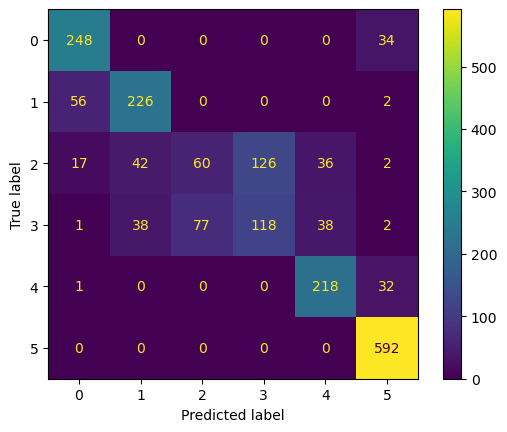

In [121]:
# Confusion matrix
svc_cm = confusion_matrix(y_test, svc_pred, labels = svc_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = svc_cm,
                              display_labels = svc_clf.classes_)
print("SVC Confusion Matrix")
disp.plot()
plt.show()

In [122]:
calculateFaultRates("SVC", svc_acc, svc_cm)


    The success rate of the SVC model on the test set: 74%
    LG_Fault(A-G) correct prediction rate: 88%"
    LLG_Fault(A-B-G) correct prediction rate: 80%"
    LLLG_Fault(A-B-C-G) correct prediction rate: 21%
    LLL_Fault(A-B-C) correct prediction rate: 43%
    LL_Fault(B-C) correct prediction rate: 87%
    NO_Fault correct prediction rate: 100%
    


In [125]:
# Train/Test Performance Metrics
svc_pm = pd.DataFrame(CalculatePerformance(svc_clf, X_train, y_train, X_test, y_test))*100
svc_pm

Model Performance Metrics Comparison


,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,76.284987,74.364191,87.485242,87.943262,77.107180,76.780186,81.969027,81.983471
1,76.284987,74.364191,80.588235,79.577465,72.949947,73.856209,76.579094,76.610169
2,76.284987,74.364191,28.823529,21.201413,51.255230,43.795620,36.897590,28.571429
3,76.284987,74.364191,45.985401,43.065693,53.769559,48.360656,49.573770,45.559846
4,76.284987,74.364191,89.641434,86.852590,79.693034,74.657534,84.375000,80.294659
5,76.284987,74.364191,100.000000,100.000000,90.137265,89.156627,94.812834,94.267516


#### 4.4.KNN Model

##### 4.4.1.Parameter Tuning

In [126]:
# Creating model
clf = KNeighborsClassifier()

params = {"n_neighbors": np.arange(1, 25)}

# Creating grid
knn_clf_grid = RandomizedSearchCV(estimator = clf, 
                                  param_distributions = params,
                                  cv = StratifiedKFold(n_splits = 10, 
                                                       shuffle = True,
                                                       random_state = seed),
                                  verbose = 2, 
                                  scoring = "accuracy",
                                  n_jobs = -1)
# Fit the model
knn_model = knn_clf_grid.fit(X_train, y_train)

# Get best parameters
print("Best parameters for KNN model: ", knn_model.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters for KNN model:  {'n_neighbors': 1}


##### 4.4.2.Building model with best parameters

In [127]:
knn_clf = KNeighborsClassifier(n_neighbors = knn_model.best_params_.get('n_neighbors'))

# Fit the model
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

##### 4.4.3.Predictions and model accuracy

In [128]:
knn_pred = knn_clf.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
print("KNN Model Accuracy:", knn_acc)
knn_acc_tr = knn_clf.score(X_train, y_train)
print("KNN Training Accuracy:", knn_acc_tr)

KNN Model Accuracy: 0.8774160732451679
KNN Training Accuracy: 1.0


##### 4.4.4.Other test parameters

In [129]:
# Classification Report
print("KNN Classification Report\n\n", classification_report(y_test, knn_pred))

KNN Classification Report

               precision    recall  f1-score   support

           0       0.97      0.99      0.98       282
           1       0.97      0.96      0.97       284
           2       0.61      0.59      0.60       283
           3       0.60      0.60      0.60       274
           4       0.98      0.99      0.99       251
           5       1.00      1.00      1.00       592

    accuracy                           0.88      1966
   macro avg       0.86      0.86      0.86      1966
weighted avg       0.88      0.88      0.88      1966



In [130]:
knn_recall = recall_score(y_test, knn_pred, average = None)
knn_precision = precision_score(y_test, knn_pred, average = None)
knn_f1 = f1_score(y_test, knn_pred, average = None)

KNN Confusion Matrix


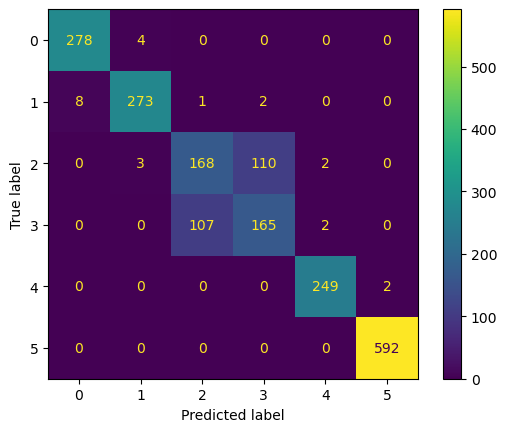

In [131]:
# Confusion matrix
knn_cm = confusion_matrix(y_test, knn_pred, labels = knn_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = knn_cm,
                              display_labels = knn_clf.classes_)
print("KNN Confusion Matrix")
disp.plot()
plt.show()

In [132]:
calculateFaultRates("KNN", knn_acc, knn_cm)


    The success rate of the KNN model on the test set: 88%
    LG_Fault(A-G) correct prediction rate: 99%"
    LLG_Fault(A-B-G) correct prediction rate: 96%"
    LLLG_Fault(A-B-C-G) correct prediction rate: 59%
    LLL_Fault(A-B-C) correct prediction rate: 60%
    LL_Fault(B-C) correct prediction rate: 99%
    NO_Fault correct prediction rate: 100%
    


In [133]:
# Train/Test Performance Metrics
knn_pm = pd.DataFrame(CalculatePerformance(knn_clf, X_train, y_train, X_test, y_test))*100
knn_pm

Model Performance Metrics Comparison


,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,100.0,87.741607,100.0,98.581560,100.0,97.202797,100.0,97.887324
1,100.0,87.741607,100.0,96.126761,100.0,97.500000,100.0,96.808511
2,100.0,87.741607,100.0,59.363958,100.0,60.869565,100.0,60.107335
3,100.0,87.741607,100.0,60.218978,100.0,59.566787,100.0,59.891107
4,100.0,87.741607,100.0,99.203187,100.0,98.418972,100.0,98.809524
5,100.0,87.741607,100.0,100.000000,100.0,99.663300,100.0,99.831366


#### 4.5.XGB Classifier

##### 4.5.1.Parameter Tuning

Note: XGB model doesn't required feature scaling. Reducing the n_splits parameter of StratifiedKfold and limitting the iterations with n_iter parameter of RandomizedSearch will speed up the process while model performance decreasing a little. Since the data set very big and training takes a lot of time we prefer this method.


In [134]:
# Creating model
clf = XGBClassifier(random_state = seed)

params = {"n_estimators": [100, 500, 1000],
          "learning_rate": [1, 0.1, 0.01, 0.001]}

# Creating grid
xg_clf_grid = RandomizedSearchCV(estimator = clf, 
                                 param_distributions = params,
                                 cv = StratifiedKFold(n_splits = 5, 
                                                      shuffle = True,
                                                      random_state = seed),
                                 n_iter = 5,
                                 verbose = 2, 
                                 scoring = "accuracy",
                                 n_jobs = -1)
# Fit the model
xg_model = xg_clf_grid.fit(X_train, y_train)

# Get best parameters
print("Best parameters for XGB model: ", xg_model.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for XGB model:  {'n_estimators': 500, 'learning_rate': 0.01}


In [135]:
xg_best = pd.DataFrame.from_dict(xg_model.best_params_, orient = "index").rename(columns = {0: "Best"})
xg_best

,Best
n_estimators,500.00
learning_rate,0.01


##### 4.5.2.Building model with best parameters

In [136]:
xg_clf = XGBClassifier(n_estimators = int(xg_best.iloc[0,0]), 
                       learning_rate = float(xg_best.iloc[1,0]),
                       random_state = seed)
# Fit the model
xg_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

##### 4.5.3.Predictions and model accuracy

In [137]:
xg_pred = xg_clf.predict(X_test)
xg_acc = accuracy_score(y_test, xg_pred)
print("XGB Model Accuracy:", xg_acc)
xg_acc_tr = xg_clf.score(X_train, y_train)
print("XGB Training Accuracy:", xg_acc_tr)

XGB Model Accuracy: 0.8357070193285859
XGB Training Accuracy: 0.8798982188295166


##### 4.5.4.Other test parameters

In [138]:
# Classification Report
print("XGB Classification Report\n\n", classification_report(y_test, xg_pred))

XGB Classification Report

               precision    recall  f1-score   support

           0       0.97      1.00      0.98       282
           1       0.96      0.96      0.96       284
           2       0.44      0.33      0.37       283
           3       0.46      0.56      0.50       274
           4       0.97      1.00      0.99       251
           5       1.00      1.00      1.00       592

    accuracy                           0.84      1966
   macro avg       0.80      0.81      0.80      1966
weighted avg       0.83      0.84      0.83      1966



In [139]:
xg_recall = recall_score(y_test, xg_pred, average = None)
xg_precision = precision_score(y_test, xg_pred, average = None)
xg_f1 = f1_score(y_test, xg_pred, average = None)

XGB Confusion Matrix


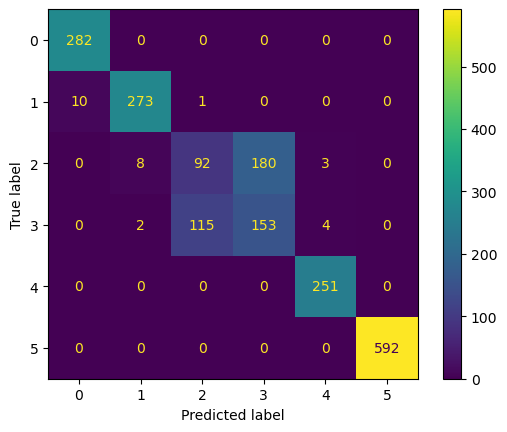

In [140]:
# Confusion matrix
xg_cm = confusion_matrix(y_test, xg_pred, labels = xg_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = xg_cm,
                              display_labels = xg_clf.classes_)
print("XGB Confusion Matrix")
disp.plot()
plt.show()

In [141]:
calculateFaultRates("XGB", xg_acc, xg_cm)


    The success rate of the XGB model on the test set: 84%
    LG_Fault(A-G) correct prediction rate: 100%"
    LLG_Fault(A-B-G) correct prediction rate: 96%"
    LLLG_Fault(A-B-C-G) correct prediction rate: 33%
    LLL_Fault(A-B-C) correct prediction rate: 56%
    LL_Fault(B-C) correct prediction rate: 100%
    NO_Fault correct prediction rate: 100%
    


In [143]:
# Train/Test Performance Metrics
xg_pm = pd.DataFrame(CalculatePerformance(xg_clf, X_train, y_train, X_test, y_test))*100
xg_pm

Model Performance Metrics Comparison


,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,87.989822,83.570702,100.000000,100.000000,97.468354,96.575342,98.717949,98.257840
1,87.989822,83.570702,97.411765,96.126761,98.454221,96.466431,97.930219,96.296296
2,87.989822,83.570702,49.411765,32.508834,62.407132,44.230769,55.154301,37.474542
3,87.989822,83.570702,68.856448,55.839416,57.578840,45.945946,62.714681,50.411862
4,87.989822,83.570702,100.000000,100.000000,99.603175,97.286822,99.801193,98.624754
5,87.989822,83.570702,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


##### 4.5.5.Feature Importances

In [144]:
# Ploting the impurity-based feature importances
feats = {} # a dictionary to hold feature_name: feature_importance
importances = xg_clf.feature_importances_
xg_clf.feature_importances_

array([0.16651908, 0.27458423, 0.15435754, 0.10059932, 0.07662102,
       0.22731884], dtype=float32)

<Axes: >

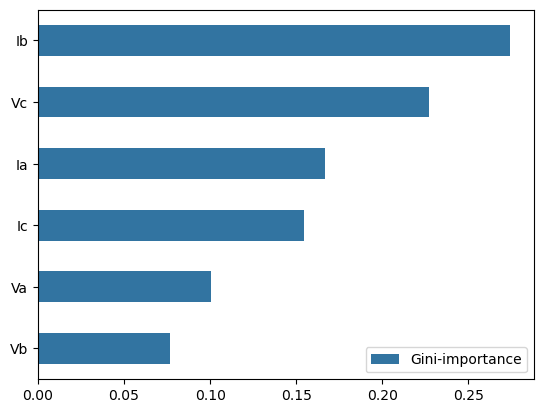

In [145]:
for feature, importance in zip(X.columns, xg_clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 
importances = pd.DataFrame.from_dict(feats, orient = "index").rename(columns = {0: "Gini-importance"})
importances = importances.sort_values(by = "Gini-importance")
importances.plot.barh(color = "#3274a1")

#### 4.6.Random Forest Model

##### 4.6.1.Parameter Tuning

In [146]:
# Creating model
clf = RandomForestClassifier(random_state = seed)

params = {"n_estimators": [100, 200, 300, 400, 500],
          "max_features": [1, 2, 3, 4, 5]}

# Creating grid
rf_clf_grid = RandomizedSearchCV(estimator = clf, 
                                 param_distributions = params,
                                 cv = StratifiedKFold(n_splits = 5, 
                                                      shuffle = True,
                                                      random_state = seed),
                                 n_iter = 5,
                                 verbose = 2, 
                                 scoring = "accuracy",
                                 n_jobs = -1)
# Fit the model
rf_model = rf_clf_grid.fit(X_train, y_train)

# Get best parameters
print("Best parameters for Random Forest model: ", rf_model.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Random Forest model:  {'n_estimators': 500, 'max_features': 3}


In [147]:
rf_best = pd.DataFrame.from_dict(rf_model.best_params_, orient = "index").rename(columns = {0: "Best"})
rf_best

,Best
n_estimators,500
max_features,3


##### 4.6.2.Building model with best parameters

In [148]:
rf_clf = RandomForestClassifier(n_estimators = int(rf_best.iloc[0,0]),
                                max_features = int(rf_best.iloc[1,0]),
                                random_state = seed)
# Fit the model
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_features=3, n_estimators=500, random_state=20)

##### 4.6.3.Predictions and model accuracy

In [149]:
rf_pred = rf_clf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Random Forest Model Accuracy:", rf_acc)
rf_acc_tr = rf_clf.score(X_train, y_train)
print("Random Forest Training Accuracy:", rf_acc_tr)

Random Forest Model Accuracy: 0.8784333672431333
Random Forest Training Accuracy: 1.0


##### 4.6.4.Other test parameters

In [150]:
# Classification Report
print("Random Forest Classification Report\n\n", classification_report(y_test, rf_pred))

Random Forest Classification Report

               precision    recall  f1-score   support

           0       0.99      1.00      0.99       282
           1       1.00      0.99      0.99       284
           2       0.58      0.58      0.58       283
           3       0.57      0.57      0.57       274
           4       1.00      1.00      1.00       251
           5       1.00      1.00      1.00       592

    accuracy                           0.88      1966
   macro avg       0.86      0.86      0.86      1966
weighted avg       0.88      0.88      0.88      1966



In [151]:
rf_recall = recall_score(y_test, rf_pred, average = None)
rf_precision = precision_score(y_test, rf_pred, average = None)
rf_f1 = f1_score(y_test, rf_pred, average = None)

Random Forest Confusion Matrix


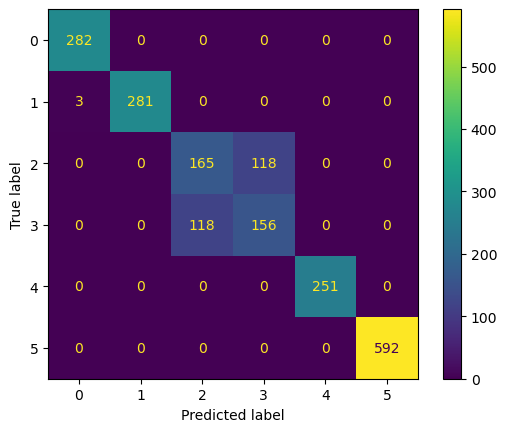

In [152]:
# Confusion matrix
rf_cm = confusion_matrix(y_test, rf_pred, labels = rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = rf_cm,
                              display_labels = rf_clf.classes_)
print("Random Forest Confusion Matrix")
disp.plot()
plt.show()

In [153]:
calculateFaultRates("Random Forest", rf_acc, rf_cm)


    The success rate of the Random Forest model on the test set: 88%
    LG_Fault(A-G) correct prediction rate: 100%"
    LLG_Fault(A-B-G) correct prediction rate: 99%"
    LLLG_Fault(A-B-C-G) correct prediction rate: 58%
    LLL_Fault(A-B-C) correct prediction rate: 57%
    LL_Fault(B-C) correct prediction rate: 100%
    NO_Fault correct prediction rate: 100%
    


In [154]:
# Train/Test Performance Metrics
rf_pm = pd.DataFrame(CalculatePerformance(rf_clf, X_train, y_train, X_test, y_test))*100
rf_pm

Model Performance Metrics Comparison


,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,100.0,87.843337,100.0,100.000000,100.0,98.947368,100.0,99.470899
1,100.0,87.843337,100.0,98.943662,100.0,100.000000,100.0,99.469027
2,100.0,87.843337,100.0,58.303887,100.0,58.303887,100.0,58.303887
3,100.0,87.843337,100.0,56.934307,100.0,56.934307,100.0,56.934307
4,100.0,87.843337,100.0,100.000000,100.0,100.000000,100.0,100.000000
5,100.0,87.843337,100.0,100.000000,100.0,100.000000,100.0,100.000000


##### 4.6.5.Feature Importances

In [155]:
# Ploting the impurity-based feature importances
feats = {} # a dictionary to hold feature_name: feature_importance
importances = rf_clf.feature_importances_
rf_clf.feature_importances_

array([0.24224582, 0.2218385 , 0.22024904, 0.11391276, 0.08835053,
       0.11340334])

<Axes: >

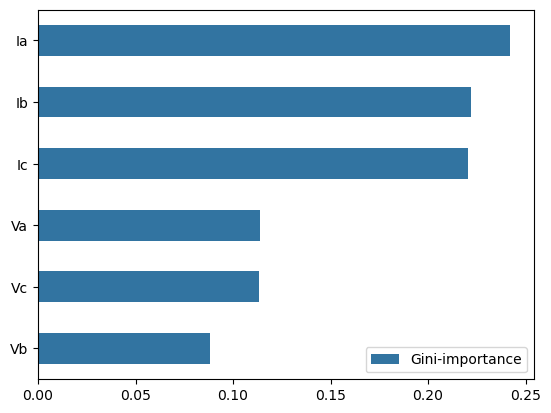

In [156]:
for feature, importance in zip(X.columns, rf_clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 
importances = pd.DataFrame.from_dict(feats, orient = "index").rename(columns = {0: "Gini-importance"})
importances = importances.sort_values(by = "Gini-importance")
importances.plot.barh(color = "#3274a1")

#### 4.7.Decision Tree Model

##### 4.7.1.Parameter Tuning

In [157]:
# Creating model
clf = DecisionTreeClassifier(random_state = seed)
path = clf.cost_complexity_pruning_path(X_train, y_train)
alphas = path["ccp_alphas"]

params = {"ccp_alpha": alphas,
          "max_features": [1, 2, 3, 4, 5]}          

# Creating grid
dt_clf_grid = RandomizedSearchCV(estimator = clf, 
                                 param_distributions = params,
                                 cv = StratifiedKFold(n_splits = 5, 
                                                      shuffle = True,
                                                      random_state = seed),
                                 n_iter = 5,
                                 verbose = 2, 
                                 scoring = "accuracy",
                                 n_jobs = -1)
# Fit the model
dt_model = dt_clf_grid.fit(X_train, y_train)

# Get best parameters
print("Best parameters for Decision Tree model:", dt_model.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Decision Tree model: {'max_features': 2, 'ccp_alpha': 0.00022618037885213457}


In [158]:
dt_best = pd.DataFrame.from_dict(dt_model.best_params_, orient = "index").rename(columns = {0: "Best"})
dt_best

,Best
max_features,2.000000
ccp_alpha,0.000226


##### 4.7.2.Building model with best parameters

In [159]:
dt_clf = DecisionTreeClassifier(max_features = int(dt_best.iloc[0,0]),
                                ccp_alpha = dt_best.iloc[1,0],
                                random_state = seed)
# Fit the model
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.00022618037885213457, max_features=2,
                       random_state=20)

##### 4.7.3.Predictions and model accuracy

In [160]:
dt_pred = dt_clf.predict(X_test)
dt_acc = accuracy_score(y_test, rf_pred)
print("Decision Tree Model Accuracy:", dt_acc)
dt_acc_tr = dt_clf.score(X_train, y_train)
print("Decision Tree Training Accuracy:", dt_acc_tr)

Decision Tree Model Accuracy: 0.8784333672431333
Decision Tree Training Accuracy: 0.934520780322307


##### 4.7.4.Other test parameters

In [161]:
# Classification Report
print("Decision Tree Classification Report\n\n", classification_report(y_test, dt_pred))

Decision Tree Classification Report

               precision    recall  f1-score   support

           0       0.98      0.99      0.99       282
           1       0.99      0.98      0.98       284
           2       0.57      0.35      0.44       283
           3       0.53      0.73      0.61       274
           4       0.99      1.00      1.00       251
           5       1.00      1.00      1.00       592

    accuracy                           0.86      1966
   macro avg       0.84      0.84      0.84      1966
weighted avg       0.87      0.86      0.86      1966



In [162]:
dt_recall = recall_score(y_test, dt_pred, average = None)
dt_precision = precision_score(y_test, dt_pred, average = None)
dt_f1 = f1_score(y_test, dt_pred, average = None)

Decision Tree Confusion Matrix


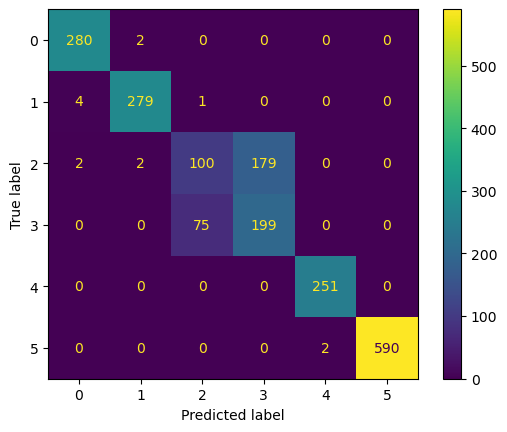

In [163]:
# Confusion matrix
dt_cm = confusion_matrix(y_test, dt_pred, labels = dt_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = dt_cm,
                              display_labels = dt_clf.classes_)
print("Decision Tree Confusion Matrix")
disp.plot()
plt.show()

In [164]:
calculateFaultRates("Decision Tree", dt_acc, dt_cm)


    The success rate of the Decision Tree model on the test set: 88%
    LG_Fault(A-G) correct prediction rate: 99%"
    LLG_Fault(A-B-G) correct prediction rate: 98%"
    LLLG_Fault(A-B-C-G) correct prediction rate: 35%
    LLL_Fault(A-B-C) correct prediction rate: 73%
    LL_Fault(B-C) correct prediction rate: 100%
    NO_Fault correct prediction rate: 100%
    


In [165]:
# Train/Test Performance Metrics
dt_pm = pd.DataFrame(CalculatePerformance(dt_clf, X_train, y_train, X_test, y_test))*100
dt_pm

Model Performance Metrics Comparison


,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,93.452078,86.419125,99.645809,99.290780,100.000000,97.902098,99.822590,98.591549
1,93.452078,86.419125,100.000000,98.239437,99.765258,98.586572,99.882491,98.412698
2,93.452078,86.419125,60.000000,35.335689,92.391304,56.818182,72.753210,43.572985
3,93.452078,86.419125,94.890511,72.627737,69.580731,52.645503,80.288214,61.042945
4,93.452078,86.419125,100.000000,100.000000,99.867374,99.209486,99.933643,99.603175
5,93.452078,86.419125,99.943598,99.662162,100.000000,100.000000,99.971791,99.830795


##### 4.7.5.Feature Importances

In [166]:
# Ploting the impurity-based feature importances
feats = {} # a dictionary to hold feature_name: feature_importance
importances = dt_clf.feature_importances_
dt_clf.feature_importances_

array([0.15757596, 0.21742368, 0.18581816, 0.30306408, 0.06704904,
       0.06906907])

<Axes: >

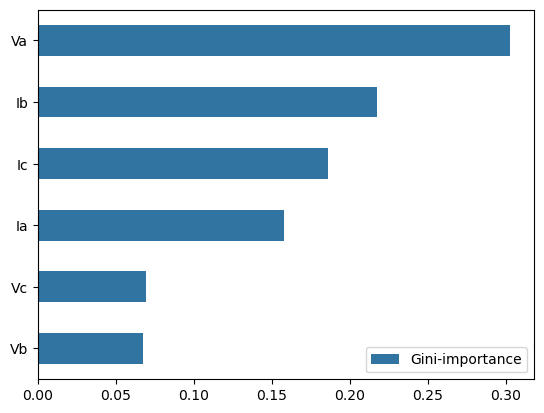

In [167]:
for feature, importance in zip(X.columns, dt_clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 
importances = pd.DataFrame.from_dict(feats, orient = "index").rename(columns = {0: "Gini-importance"})
importances = importances.sort_values(by = "Gini-importance")
importances.plot.barh(color = "#3274a1")

### 5.Model Comparison

#### 5.1.Metrics list and comparison table

In [168]:
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
model_names = ["LogisticRegression", "SVC", "KNN", "XGB", 
              "RandomForest", "DecisionTree"]
models = [lr_clf, svc_clf, knn_clf, xg_clf, rf_clf, dt_clf]
pred_list = [lr_pred, svc_pred, knn_pred, xg_pred, rf_pred, dt_pred]
accuracy_list = [lr_acc, svc_acc, knn_acc, xg_acc, rf_acc, dt_acc]
cm_list = [lr_cm, svc_cm, knn_cm, xg_cm, rf_cm, dt_cm]
f1_list = [lr_f1, svc_f1, knn_f1, xg_f1, rf_f1, dt_f1]
performs = [lr_pm, svc_pm, knn_pm, xg_pm, rf_pm, dt_pm]
precision_list = [lr_precision, svc_precision, knn_precision, 
                  xg_precision, rf_precision], dt_precision
recall_list = [lr_recall, svc_recall, knn_recall, xg_recall, rf_recall, dt_recall]
train_accuracy = [lr_acc_tr, svc_acc_tr, knn_acc_tr, xg_acc_tr, rf_acc_tr, dt_acc_tr]

#### 5.2.Barplot for comparison of all metrics and models

In [169]:
def compare_metrics_barplot(comparison_list, model_list, metric_list, color_list):
    size = range(len(model_list))
    color_list = cmap
    w = 0.15    
    
    # Selecting metrics one by one for all models
    def select_metrics(comparison_list, metric_list):
        row_list = []
        for metric in metric_list:
            row_out = list(comparison_list.loc[metric])
            row_list.append(row_out)
        return row_list
    
    y = select_metrics(comparison_list, metric_list)
    
    # Figure size
    plt.figure(figsize = (10, 5))
    # Positions, colors, labels and axes
    for i in range(len(metric_list)):
        plt.bar([pos + (i * w) for pos in size], 
                y[i], 
                width = w, 
                align = "center", 
                label = metric_list[i],
                color = color_list[i]) 
    # Display plot    
    plt.xlabel("Metrics")
    plt.ylabel("Rate")
    plt.title("All Metrics Comparison by Model's Built Order")
    plt.xticks([pos + (2.5 * w) for pos in size], model_list, rotation = 90)
    plt.yticks(np.arange(0, 105, 5))
    plt.legend(bbox_to_anchor = (1, 1), loc = "best")
    plt.show()

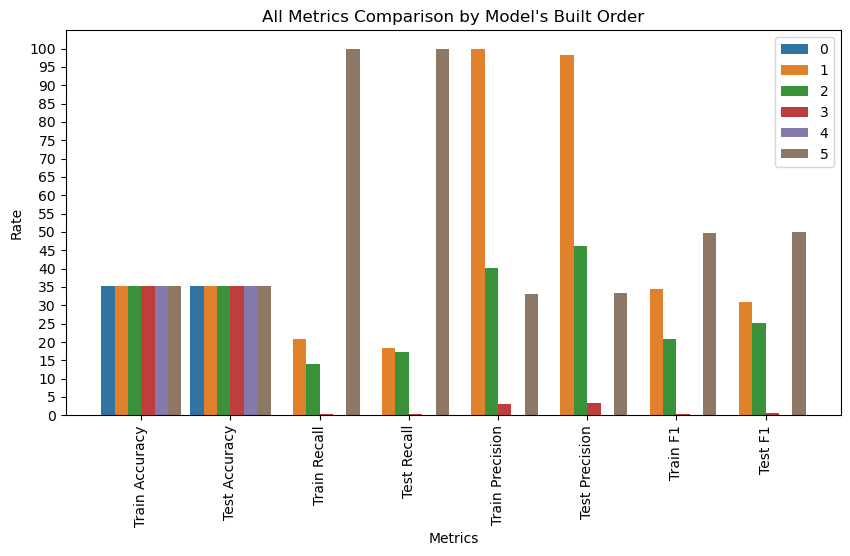

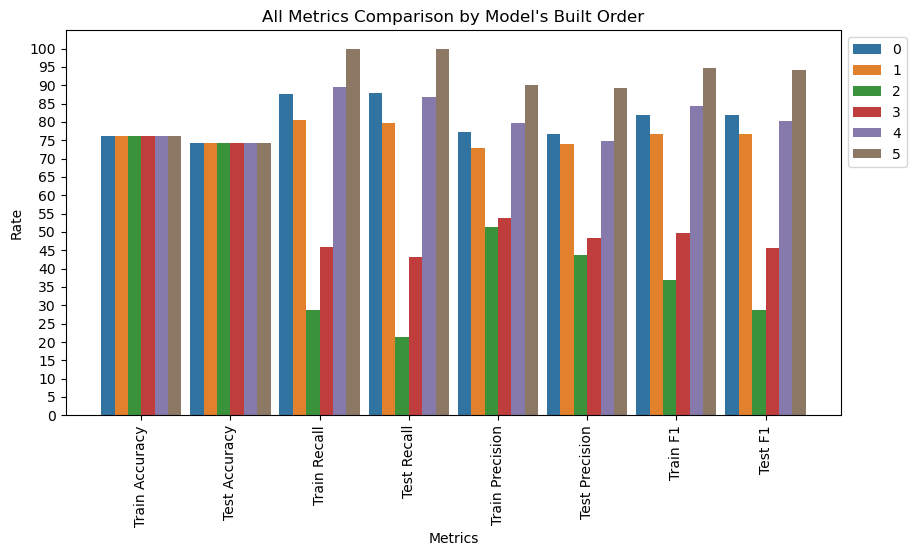

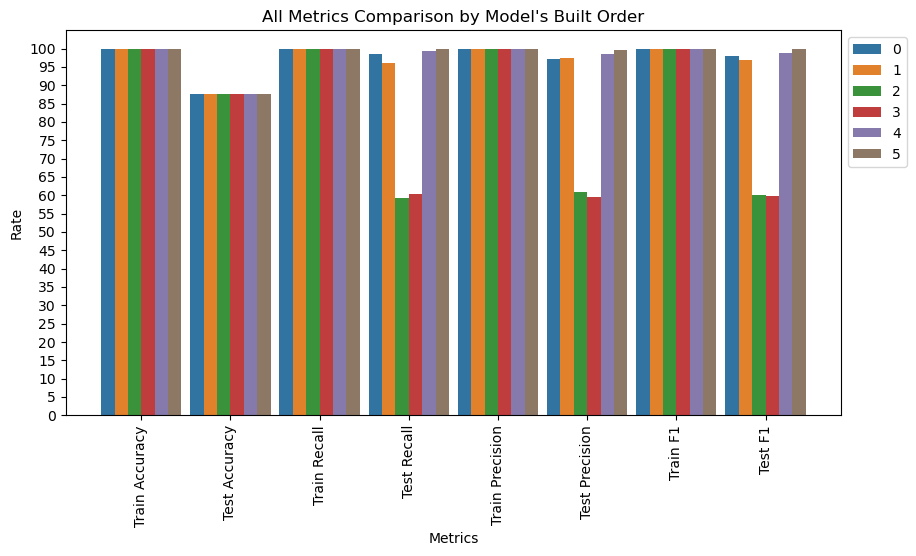

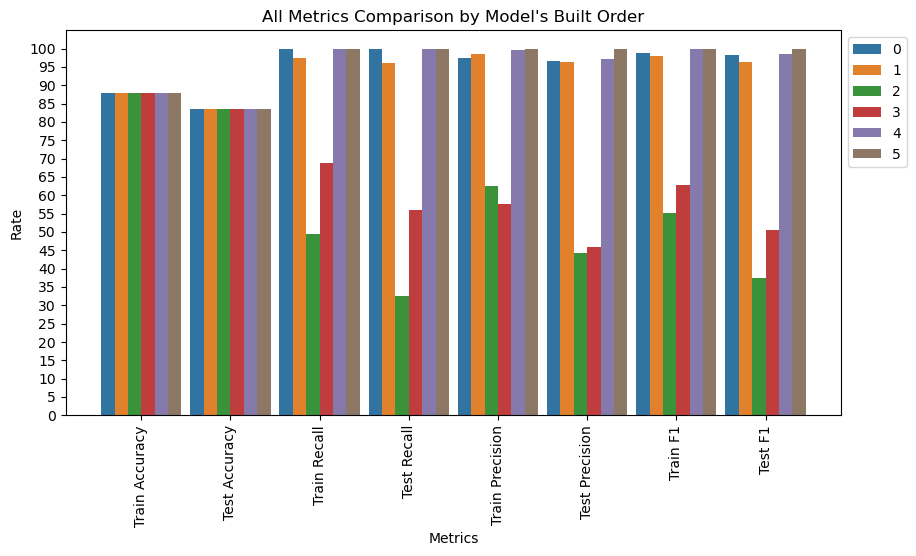

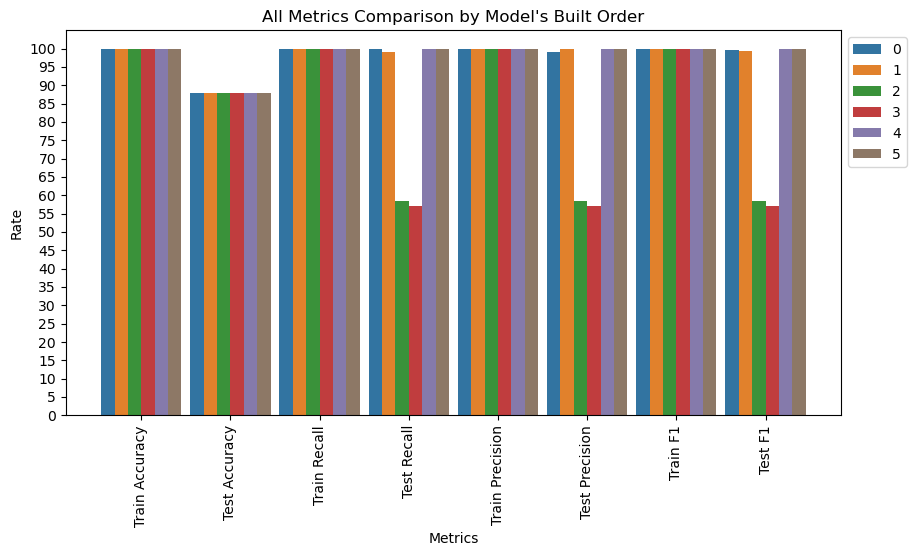

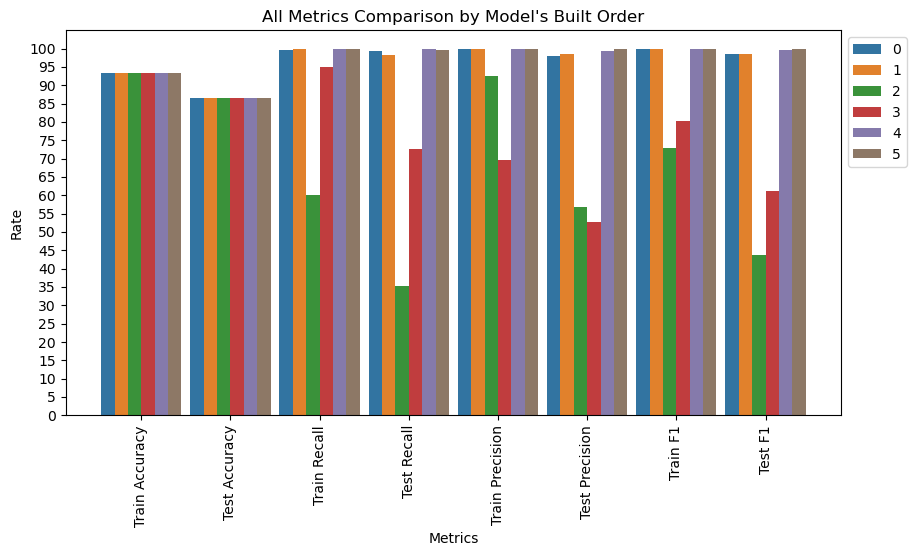

In [170]:
for p in performs:
    compare_metrics_barplot(p, p.columns.to_list(), p.index.to_list(), cmap)

#### 5.3.Comparison of models test & training accuracies

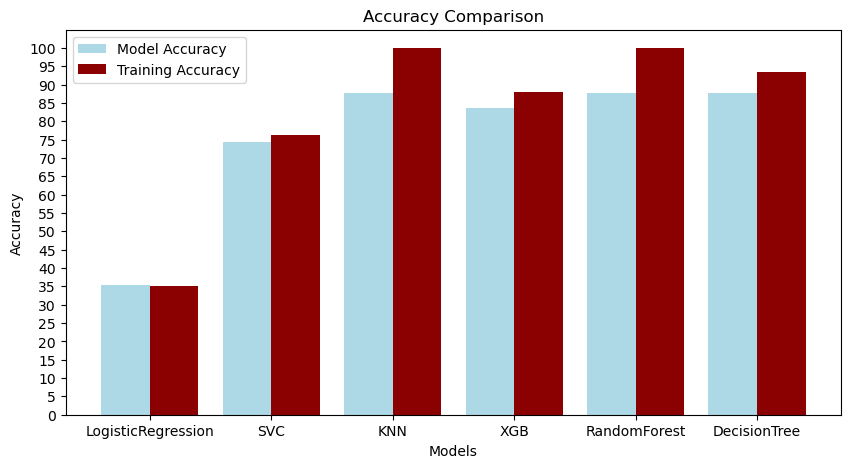

In [171]:
plt.figure(figsize = (10, 5))

plt.bar(np.arange(len(model_names)) - 0.2, 
        np.array(accuracy_list)*100, 0.4, label = "Model Accuracy", color = "lightblue") 
plt.bar(np.arange(len(model_names)) + 0.2, 
        np.array(train_accuracy)*100, 0.4, label = "Training Accuracy", color = "darkred") 
plt.xticks(np.arange(len(model_names)), model_names)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.yticks(np.arange(0, 105, 5))
plt.legend()
plt.show()

#### 5.4.Comparison of confusion matrices

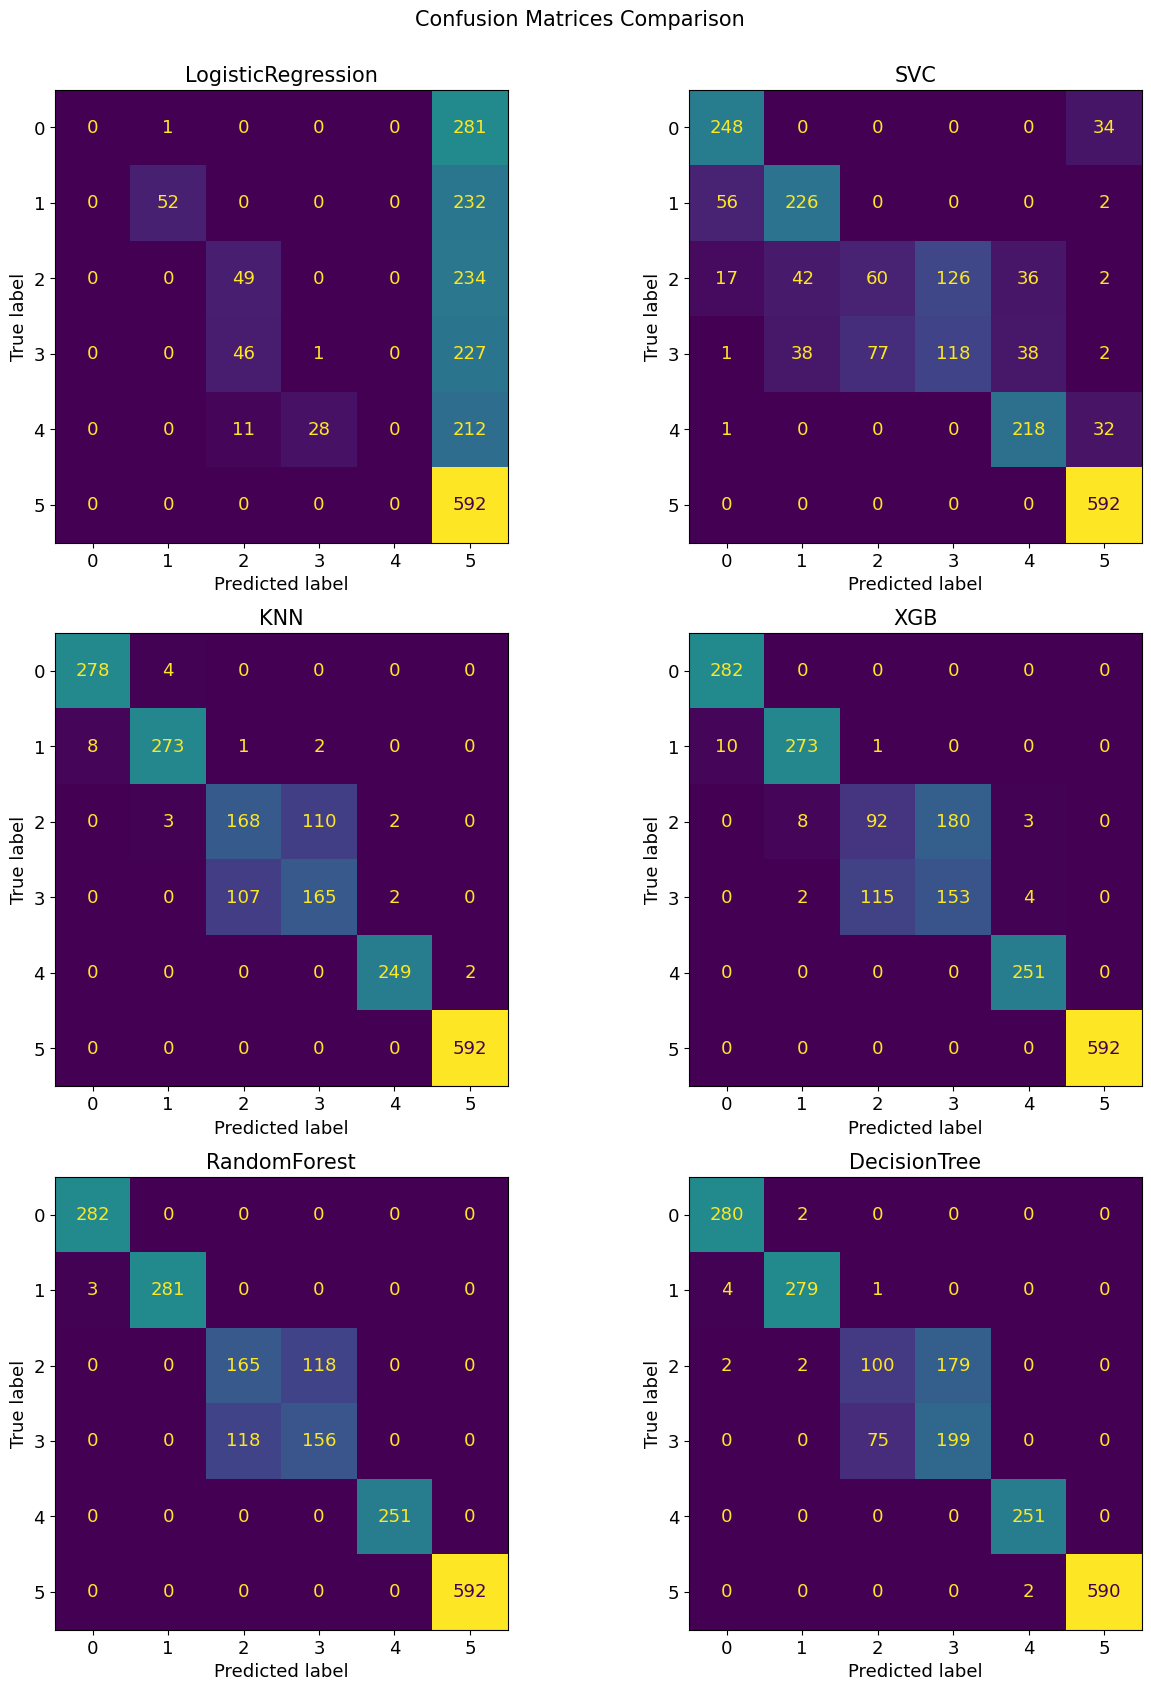

In [172]:
title_size = 15
plt.rcParams.update({"font.size": 13})
color_map = "viridis"
colorbar = False

# Subplots
f, axes = plt.subplots(3, 2, figsize = (15, 20))

for i, j in np.ndindex(axes.shape):

        axes[i, j].set_title(model_names[2*i + j], size = title_size)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm_list[2*i + j], 
                                      display_labels = models[2*i + j].classes_)
        disp.plot(include_values = True, cmap = color_map, ax = axes[i, j], colorbar = colorbar)
    
f.suptitle("Confusion Matrices Comparison", size = title_size, y=0.92)
plt.show()

### 6.Summary and Conclusion

Random Forest & KNN have the best accuracy scores. Decision Tree, XGB & SVC follows in order. Logistic Regression has the worst accuracy score. It predicts only NO_Fault type correctly.

As can be seen from the confusion matrices, Decision Tree, Random Forest and XGB models predicted almost all of NO_Fault, LG_Fault(A-G) and LL_Fault(B-C) types correctly. All models having difficulties to predict LLLG_Fault(A-B-C-G) and LLL_Fault(A-B-C). Even in the models having best accuracies, the prediction rates of these faults remain in the 40 - 60% range.

On the other hand for an electrical system we should predict faults better than normal values. Thus, our chance of intervening in them increases. For instance one of the errors that the models here predict most incorrectly is phase-phase, and the other is phase-ground error, each of them require different protection precautions.

After all the **Random Forest** model looks like the most balanced model.